In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn import metrics,preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, confusion_matrix,roc_auc_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import math
import toad
from matplotlib import pyplot as plt
from toad.metrics import KS,F1,AUC
import seaborn as sns
import warnings
import plotly.offline as py
import cufflinks as cf
import plotly.graph_objs as go
import lightgbm as lgb
import re

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 138)
pd.set_option('display.max_columns', 200)

C:\Users\DELL\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# 一、完成步骤
 
竞赛链接的如下：[https://www.kaggle.com/c/home-credit-default-risk/data] 
    
## **完成该kaggle竞赛步骤如下：**

（1）数据探索
  
（2）数据清洗

（3）特征构造

（4）模型选择和处理

（5）模型评估和预测



# 二、选取比赛介绍
## （1）比赛介绍
  &#8195;&#8195;由于信用记录不足或不存在，许多人难以获得贷款。而且，不幸的是，这些人经常被不值得信赖的贷方利用。"Home Credit Default Risk Project"正是捷信集团在这种背景下于2018年推出的预测大赛,旨在鼓励参赛者使用各种统计和机器学习方法,预测出最优的结果。
## （2）具体问题和目的
  &#8195;&#8195;为了解决一部分信息不对称问题，确保这些信息不足的人群获得积极的贷款体验，参赛者需要从比赛提供的想要申请贷款客户的各种替代数据——包括电信和交易信息中提取有效信息,最终预测客户的还款能力。
## （3）选取该比赛原因
  &#8195;&#8195;该比赛契合本专业的知识背景，实际是金融问题中最典型的信用管理问题。研究小组试图通过本学期所学的机器学习知识和自身的金融知识背景，重新体验比赛过程，最终实现学以致用。

# 三、比赛数据介绍

**数据导入**

In [2]:
application=pd.read_csv('application_train.csv')
application_test=pd.read_csv('application_test.csv')
bureau=pd.read_csv('bureau.csv')
bureau_balance=pd.read_csv('bureau_balance.csv')
credit_card=pd.read_csv('credit_card_balance.csv')
insta_payments=pd.read_csv('installments_payments.csv')
pos_cash=pd.read_csv('POS_CASH_balance.csv')
previous_application=pd.read_csv('previous_application.csv')
test=pd.read_csv('application_test.csv')

## （1）数据来源
本文的数据由Home Credit公司提供，Home Credit (捷信)是中东欧以及亚洲领先的消费金融提供商之一。在中东欧（CEE），俄罗斯，独联体国家（CIS）和亚洲各地服务于消费者。预测客户是否偿还贷款或遇到困难是一项重要的业务需求,本赛题致力于向无银行账户的人群提供信贷（贷款）。

Home Credit公司本质业务是金融服务，即发放贷款并靠此盈利的公司，而信贷公司为在本公司缺乏信用记录的公司放贷是要承担巨额风险的。

这里介绍冷启动这个概念。当信贷业务起步时，我们根本没有贷后表现样本，但此时仍需要风控系统来保驾护航，而不会选择“裸奔”。巧妇难为无米之炊，如果没有数据进行支撑，所有的模型、策略都只是空中阁楼，这种困境被人们称之为风控系统的冷启动问题。所以为解决该问题，我们可以是查询用户在信用局的历史征信记录来作为风险评估的参考，数据文件中的bureau.csv和 bureau_balance.csv 就对应这部分数据。

Home Credit公司还专门设计了许多入门级金融产品来建立自己的信用体系，增加客户的依赖性和粘性。他有三类产品，信用卡(credit card)，消费贷(Point of sales loan–POS loan)，现金贷(Installment cash loan)。  

POS loans的体系图如下图所示：
![](22.png)

Point-of-sale (POS) loans是一款初级产品，专门争对一些价格较低的临售商品，引导客户通过对小额商品使用Point-of-sale (POS) loans进行分期付款来建立用户对该项目的依赖，就很像我们常用的支付宝的花呗功能。POS_CASH_balance.csv 中的数据就来源于此。  
在此基础上衍生出的进阶产品就有Credit cards，可以理解为信用贷款，类似于支付宝的借呗功能，信用卡在欧洲和美国很流行，但在中东欧以及亚洲并非如此。所以数据集中信用卡数据偏少。用户使用该产品产生的信用记录就对应于credit_card_balance.csv 中的数据。  
而现金贷可以得到现金，用户使用该产品的申请和还款记录数据对应installments_payment.csv。
## （2）数据意义
### 根据上面的介绍，数据集包括了8个数据文件：
**application_train / application_test：**测试集和训练集记录了关于Home Credit每个贷款申请的信息。每一行代表一笔贷款，并由功能SK_ID_CURR标识。培训申请数据附带TARGET表示0：贷款已还清或1：贷款未还清。  
**bureau：**为解决冷启动问题而特意收集的，有关客户之前来自其他金融机构的信贷的数据。以前的每一笔信贷都有自己的分行，所以申请数据中的一笔贷款可能有多笔先前信贷，可以更具特征进行合并。  
**bureau_balance：**关于信贷局以前收集到的每位客户信用的月度数据。一个先前的信用可以有多个行，每个信用额度的每个月有一个行。  
**previous_application：**之前就申请过贷款的客户在Home Credit贷款申请。申请数据中的每个当前贷款都可以有多个以前的贷款。每个以前的应用程序都有一行，并由功能SK_ID_PREV标识。  
**pose_cash_balanc：** 专门针对小额贷款项目所设计的贷款账目表。每一行都是前一个销售点或现金贷款的一个月，以前的一笔贷款可以有多行。  
**credit_card_balance：**可以理解为在Point-of-sale (POS) loans基础上提出的进阶产品。有关之前的信用卡客户与Home Credit有关的每月数据。每行都是信用卡余额的一个月，一张信用卡可以有多行。  
**installments_payment：**Home Credit以前贷款的付款记录。每笔付款都有一行，每笔未付款都有一行。

下图显示了所有数据是如何相关的，通过三个ID将三部分数据联系起来：SK_ID_CURR，SK_ID_BUREAU和SK_ID_PREV。

![](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

## （3）表内数据


In [4]:
toad.detector.detect(application).head(20)

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
SK_ID_CURR,int64,307511,0.00%,307511,278180.518577,102790.175348,100002.0,103590.2,135692.0,278202.0,367142.5,420729.0,452712.9,456255.0
TARGET,int64,307511,0.00%,2,0.080729,0.272419,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
NAME_CONTRACT_TYPE,object,307511,0.00%,2,Cash loans:90.48%,Revolving loans:9.52%,None,None,None,None,None,None,Cash loans:90.48%,Revolving loans:9.52%
CODE_GENDER,object,307511,0.00%,3,F:65.83%,M:34.16%,XNA:0.00%,None,None,None,None,F:65.83%,M:34.16%,XNA:0.00%
FLAG_OWN_CAR,object,307511,0.00%,2,N:65.99%,Y:34.01%,None,None,None,None,None,None,N:65.99%,Y:34.01%
FLAG_OWN_REALTY,object,307511,0.00%,2,Y:69.37%,N:30.63%,None,None,None,None,None,None,Y:69.37%,N:30.63%
CNT_CHILDREN,int64,307511,0.00%,15,0.417052,0.722121,0.0,0.0,0.0,0.0,1.0,2.0,3.0,19.0
AMT_INCOME_TOTAL,float64,307511,0.00%,2548,168797.919297,237123.146279,25650.0,45000.0,81000.0,147150.0,202500.0,270000.0,472500.0,117000000.0
AMT_CREDIT,float64,307511,0.00%,5603,599025.999706,402490.776996,45000.0,76410.0,180000.0,513531.0,808650.0,1133748.0,1854000.0,4050000.0
AMT_ANNUITY,float64,307511,0.00%,13672,27108.573909,14493.737315,1615.5,6182.91,11074.5,24903.0,34596.0,45954.0,70006.5,258025.5


# 四、关键问题拆分

**根据以上题目设定，可以将该赛题主要拆分为以下几个关键问题：**

（1）众多数据表如何合并？ 

（2）缺失值和异常值该如何处理？ 

（3）如何利用原始数据，生成有商业意义的新变量(新特征)？  

（4）模型以及参数如何选择？ 

**针对以上问题，我们进行了以下的数据探索与分析：**

# 五、整体思路
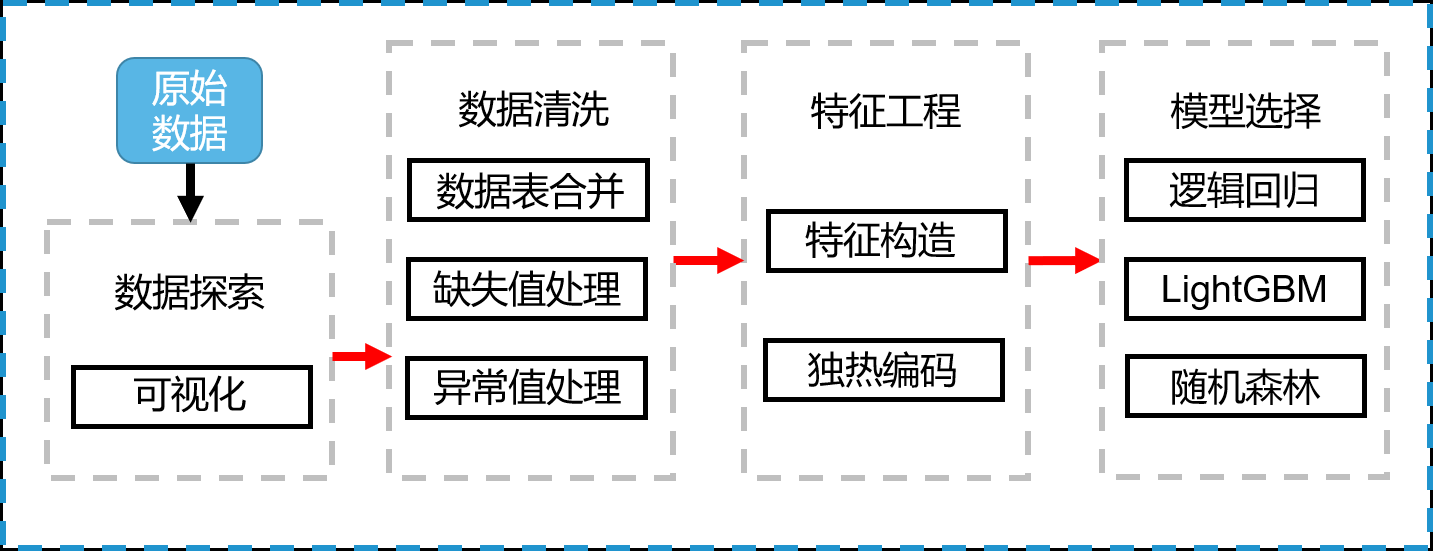


# 六、数据初步探索

**首先，我们对整体客户的关键属性进行了分析，具体如下所示：**

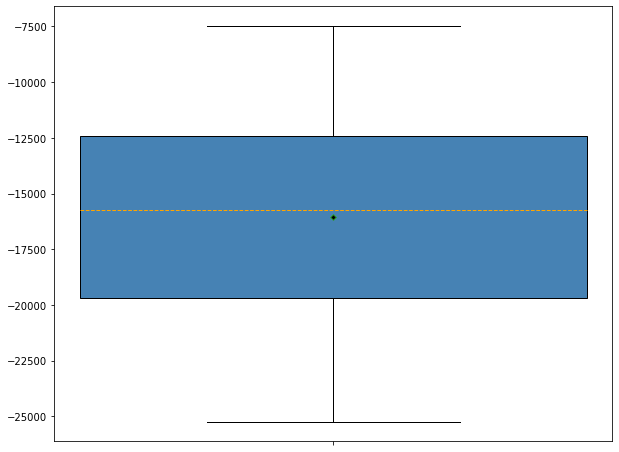

In [5]:
fig=plt.figure(figsize=(10,8))
plt.boxplot(x =application['DAYS_BIRTH'] ,
         whis = 1.5, 
         widths = 3.0,
         patch_artist = True, 
         showmeans = True, 
         boxprops = {'facecolor':'steelblue'}, 
         flierprops = {'markerfacecolor':'red', 'markeredgecolor':'red', 'markersize':4}, 
        meanprops = {'marker':'D','markerfacecolor':'black', 'markersize':4}, 
         medianprops = {'linestyle':'--','color':'orange'}, 
         labels = [''] 
         )
plt.show()

<AxesSubplot:xlabel='target', ylabel='count'>

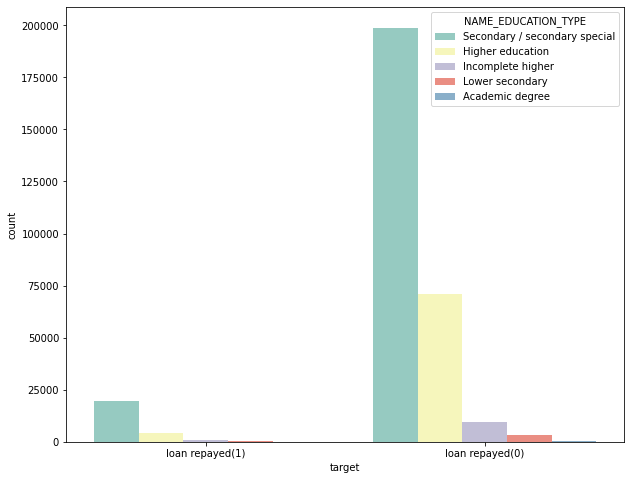

In [6]:
application.loc[application["TARGET"] == 0, "target"] = 'loan repayed(0)'
application.loc[application["TARGET"] == 1, "target"] = 'loan repayed(1)'
plt.figure(figsize=(10,8))
sns.countplot(x=application.target, 
              hue=application.NAME_EDUCATION_TYPE,
              palette='Set3')

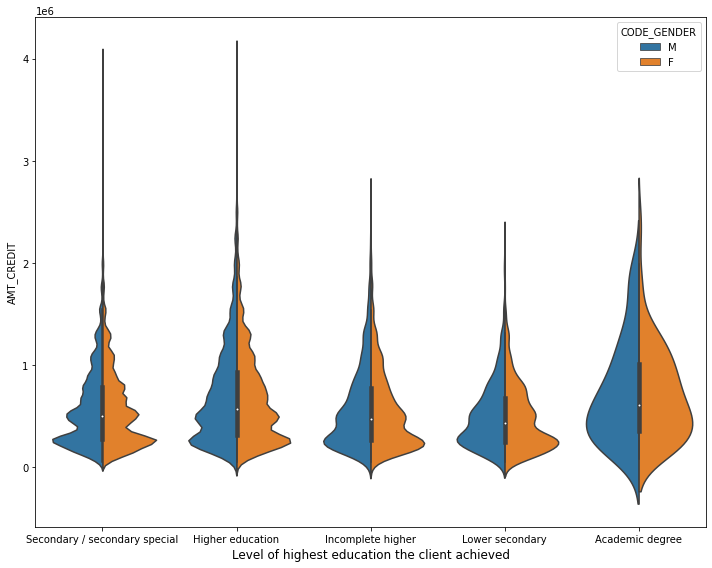

In [7]:
df=application[(application['CODE_GENDER']=='F')|(application['CODE_GENDER']=='M')]
fig=plt.figure(figsize=(10,8))
ax=sns.violinplot(x="NAME_EDUCATION_TYPE",
                  y="AMT_CREDIT",
                  data=df,
                  hue="CODE_GENDER",
                  split=True,
                  scale_hue=True
                  )
plt.xlabel('Level of highest education the client achieved',fontsize=12)
plt.tight_layout()

In [7]:
cf.set_config_file(offline=True,theme='polar')
contract_val=application['FLAG_OWN_CAR'].value_counts()
contract_df=pd.DataFrame({'labels':['Yes (Y)','No (N)'],'values':contract_val.values})
contract_df.iplot(kind='pie',labels='labels',values='values',title='OWN CAR or not',hole=0.6)

In [8]:
cf.set_config_file(offline=True,theme='polar')
contract_val=application['FLAG_OWN_REALTY'].value_counts()
contract_df=pd.DataFrame({'labels':['Yes (Y)','No (N)'],'values':contract_val.values})
contract_df.iplot(kind='pie',labels='labels',values='values',title='OWN REALTY or not',hole=0.6)
plt.show()

<Figure size 720x576 with 0 Axes>

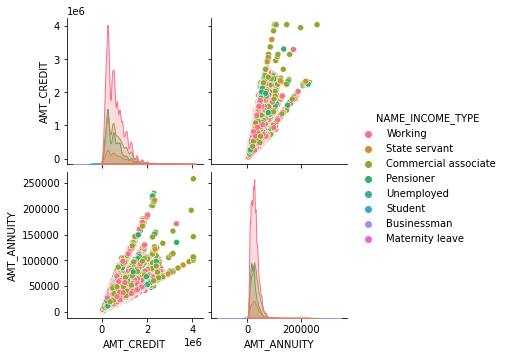

In [11]:
fig=plt.figure(figsize=(10,8))
sns.pairplot(application, vars=["AMT_CREDIT","AMT_ANNUITY"],hue='NAME_INCOME_TYPE',palette="husl")
plt.show()

In [9]:
income_val=application['NAME_HOUSING_TYPE'].value_counts()
income_val_y0=[]
income_val_y1=[]
for val in income_val.index:
    income_val_y1.append(np.sum(application['TARGET'][application['NAME_HOUSING_TYPE']==val]==1))
    income_val_y0.append(np.sum(application['TARGET'][application['NAME_HOUSING_TYPE']==val]==0))
data=[go.Bar(x=income_val.index,y=((income_val_y1/income_val.sum())*100),name='Not repayed'),
      go.Bar(x=income_val.index,y=((income_val_y0/income_val.sum())*100),name='Repayed')]
layout=go.Layout(title="Housing type of Applicants with loan is repayed or not percentage",
                 xaxis=dict(title='Housing type'),
                 yaxis=dict(title='Percentage in applicants'))
fig=go.Figure(data=data,layout=layout)
py.iplot(fig)

以下是通过绘制箱线图发现的异常值

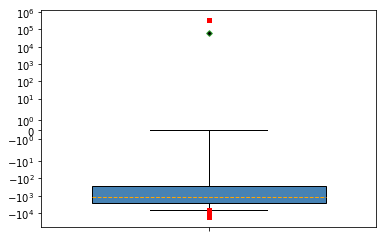

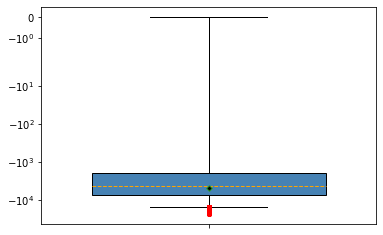

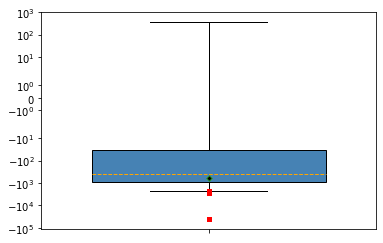

In [11]:
plt.boxplot(x =application['DAYS_EMPLOYED'] , 
         whis = 1.5,
         widths = 0.7, 
         patch_artist = True, 
         showmeans = True,
         boxprops = {'facecolor':'steelblue'}, 
         flierprops = {'markerfacecolor':'red', 'markeredgecolor':'red', 'markersize':4}, 
        meanprops = {'marker':'D','markerfacecolor':'black', 'markersize':4}, 
         medianprops = {'linestyle':'--','color':'orange'}, 
         labels = [''] 
         )
plt.yscale('symlog')
plt.show()

plt.boxplot(x =application['DAYS_REGISTRATION'] , 
         whis = 1.5, 
         widths = 0.7, 
         patch_artist = True, 
         showmeans = True, 
         boxprops = {'facecolor':'steelblue'}, 
         flierprops = {'markerfacecolor':'red', 'markeredgecolor':'red', 'markersize':4}, 
        meanprops = {'marker':'D','markerfacecolor':'black', 'markersize':4}, 
         medianprops = {'linestyle':'--','color':'orange'}, 
         labels = [''] 
         )
plt.yscale('symlog')
plt.show()

plt.boxplot(x =bureau['DAYS_CREDIT_UPDATE'] , 
         whis = 1.5, 
         widths = 0.7, 
         patch_artist = True, 
         showmeans = True, 
         boxprops = {'facecolor':'steelblue'}, 
         flierprops = {'markerfacecolor':'red', 'markeredgecolor':'red', 'markersize':4}, 
        meanprops = {'marker':'D','markerfacecolor':'black', 'markersize':4}, 
         medianprops = {'linestyle':'--','color':'orange'}, 
         labels = [''] 
         )
plt.yscale('symlog')
plt.show()

**关键发现：**
 - 客群中主要以34到54的中年人为主，最年轻的客户是20岁，最年长的客户是69岁。
 - 学历为Secondary / secondary special的的客户占比最大，约有218391人，占总体72.68%,其次是Higher education款，占24.3%；占比最少的是Lower secondary和Academic degree，分别占总客户数的3.34%与1.24%。
 - 文凭在大学以及以上的客户未还款的概率明显低于文凭为初高中的客户，可以推知文凭与是否还款之间有明显相关关系
 - 相同文凭的男性和女性客户在信用额度分布上保持基本一致，说明性别与信用额度几乎无关。
 - 拥有车辆的客户有202924人，占比66%，未拥有车辆的客户占比34%。拥有房产的客户有213312人，占比69.4%，未拥有房产的客户占比30.6%。
 - 居住情况中住在House/apartment占大多数，占比88.72%，在House/apartment居住的客户中未还款的客户占总体客户比6.91%，还款客户占总体客户比例81.81%
 - 申请者的年收入中位数数量级为$10^5$，且收入数据中的异常值出现的频率是最多的。其中申请者的信用额度中位数数量级$10^6$，申请者年金的中位数数量级约为$10^4$。

## **七、数据预处理**

## （1）数据表合并

**&#8195;&#8195;类别类型和数值类型的数据表的重构步骤基本相同，但类别类型的数据表首先需要分类变量转换为虚拟/指标变量,并选中所需类型的数据，然后利用python的更新规则实现了数据集的更新。随后两种类型的数据表的重构步骤都相同，我们先去除了数据表的原有分类标准，并依照我们选中的新的分类标准实现了重新分组,分别选出了两种类型的数据并求出了均值。接下来我们利用两张表中共有的数据将两张表中的数据进行合并,同时实现了对于列的筛选和重组。然后我们保留了左侧的数据并实现了更新，最后将缺失值都以0进行了填补。** 

![avatar](12.png)


In [12]:
#结合数值类特征
# 将按数值类别取均值的分组结果转化为dataframe对象
grp=bureau.drop('SK_ID_BUREAU',axis=1).groupby(by='SK_ID_CURR').mean().reset_index()
# 重新命名
grp.columns=['BUREAU_'+column if column!='SK_ID_CURR'else column for column in grp.columns]
# application和bureau表合并
application_bureau=application.merge(grp,on='SK_ID_CURR',how='left')
test=test.merge(grp,on='SK_ID_CURR',how='left')
# 缺失值处理
application_bureau.update(application_bureau[grp.columns].fillna(0))
test.update(test[grp.columns].fillna(0))
#结合分类特征
bureau_categorical=pd.get_dummies(bureau.select_dtypes('object'))
bureau_categorical['SK_ID_CURR']=bureau['SK_ID_CURR']
grp=bureau_categorical.groupby(by='SK_ID_CURR').mean().reset_index()
grp.columns=['BUREAU_'+column if column!='SK_ID_CURR'else column for column in  grp.columns]
application_bureau=application_bureau.merge(grp,on='SK_ID_CURR',how='left')
test=test.merge(grp,on='SK_ID_CURR',how='left')
test.update(test[grp.columns].fillna(0))

In [13]:
#结合数值型的特征
grp=previous_application.drop('SK_ID_PREV',axis=1).groupby(by='SK_ID_CURR').mean().reset_index()
prev_columns=['PREV_'+column if column!='SK_ID_CURR'else column for column in grp.columns]
grp.columns=prev_columns
application_bureau_prev=application_bureau.merge(grp,on=['SK_ID_CURR'],how='left')
test=test.merge(grp,on=['SK_ID_CURR'],how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
test.update(test[grp.columns].fillna(0))
#结合类别特征
prev_catgorical=pd.get_dummies(previous_application.select_dtypes('object'))
prev_catgorical['SK_ID_CURR']=previous_application['SK_ID_CURR']
grp=prev_catgorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns=['PREV_'+column if column!='SK_ID_CURR'else column for column in grp.columns]
application_bureau_prev=application_bureau_prev.merge(grp,on='SK_ID_CURR',how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
test=test.merge(grp,on='SK_ID_CURR',how='left')
test.update(test[grp.columns].fillna(0))

In [14]:
#结合数值型的特征
grp=pos_cash.drop('SK_ID_PREV',axis=1).groupby(by='SK_ID_CURR').mean().reset_index()
prev_columns=['POS_'+column if column!='SK_ID_CURR'else column for column in grp.columns]
grp.columns=prev_columns
application_bureau_prev=application_bureau_prev.merge(grp,on=['SK_ID_CURR'],how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
test=test.merge(grp,on=['SK_ID_CURR'],how='left')
test.update(test[grp.columns].fillna(0))
#结合类别特征
pos_cash_catgorical=pd.get_dummies(pos_cash.select_dtypes('object'))
pos_cash_catgorical['SK_ID_CURR']=previous_application['SK_ID_CURR']
grp=pos_cash_catgorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns=['POS_'+column if column!='SK_ID_CURR'else column for column in grp.columns]
application_bureau_prev=application_bureau_prev.merge(grp,on='SK_ID_CURR',how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))  
test=test.merge(grp,on=['SK_ID_CURR'],how='left')
test.update(test[grp.columns].fillna(0))

In [15]:
#结合数值型的特征
grp=insta_payments.drop('SK_ID_PREV',axis=1).groupby(by='SK_ID_CURR').mean().reset_index()
prev_columns=['INSTA_'+column if column!='SK_ID_CURR'else column for column in grp.columns]
grp.columns=prev_columns
application_bureau_prev=application_bureau_prev.merge(grp,on=['SK_ID_CURR'],how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
test=test.merge(grp,on=['SK_ID_CURR'],how='left')
test.update(test[grp.columns].fillna(0))

In [16]:
#结合数值型的特征
grp=credit_card.drop('SK_ID_PREV',axis=1).groupby(by='SK_ID_CURR').mean().reset_index()
prev_columns=['CREDIT_'+column if column!='SK_ID_CURR'else column for column in grp.columns]
grp.columns=prev_columns
application_bureau_prev=application_bureau_prev.merge(grp,on=['SK_ID_CURR'],how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
test=test.merge(grp,on=['SK_ID_CURR'],how='left')
test.update(test[grp.columns].fillna(0))
#结合类别特征
credit_catgorical=pd.get_dummies(credit_card.select_dtypes('object'))
credit_catgorical['SK_ID_CURR']=credit_card['SK_ID_CURR']
grp=credit_catgorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns=['CrREDIT_'+column if column!='SK_ID_CURR'else column for column in grp.columns]
application_bureau_prev=application_bureau_prev.merge(grp,on='SK_ID_CURR',how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))  
test=test.merge(grp,on=['SK_ID_CURR'],how='left')
test.update(test[grp.columns].fillna(0))

## （2）缺失值处理 

In [17]:
y=application_bureau_prev.pop('TARGET').values
id_train=application_bureau_prev['SK_ID_CURR']
id_test=test['SK_ID_CURR']
application_bureau_prev=application_bureau_prev.drop(['SK_ID_CURR'],axis=1)
test=test.drop(['SK_ID_CURR'],axis=1)
#将特征分成数值和类别特征
types=np.array([dt for dt in application_bureau_prev.dtypes])
all_columns=application_bureau_prev.columns.values
is_num=types!='object'
num_cols=all_columns[is_num]
cat_cols=all_columns[~is_num]
#处理数值特征缺失值——取中位数
imputer_num=SimpleImputer(strategy='median')
data_num=imputer_num.fit_transform(application_bureau_prev[num_cols])
test_num=imputer_num.transform(test[num_cols])
scaler_num=StandardScaler()
data_num1=scaler_num.fit_transform(data_num)
test_num1=scaler_num.transform(test_num)
data_num_final=pd.DataFrame(data_num1,columns=num_cols)
test_num_final=pd.DataFrame(test_num1,columns=num_cols)
#处理类别特征——增加MISSING类
imputer_cat=SimpleImputer(strategy='constant',fill_value='MISSING')
data_cat=imputer_cat.fit_transform(application_bureau_prev[cat_cols])
data_cat1=pd.DataFrame(data_cat,columns=cat_cols)
test_cat=imputer_cat.transform(test[cat_cols])
test_cat1=pd.DataFrame(test_cat,columns=cat_cols)
application_bureau_prev=pd.concat([data_num_final,data_cat1,id_train],axis=1)
test=pd.concat([test_num_final,test_cat1,id_test],axis=1)

## （3）异常值处理 

In [18]:
def wiebitte1(x):
    if x >0 or x<-10000: 
        return -2436
    else :
        return x

In [19]:
application_bureau_prev['DAYS_EMPLOYED'] = application_bureau_prev['DAYS_EMPLOYED'].apply(lambda x:wiebitte1(x))
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x:wiebitte1(x))

In [20]:
def wiebitte2(x):
    if x < -15000: 
        return -4536
    else :
        return x

In [21]:
application_bureau_prev['DAYS_REGISTRATION'] = application_bureau_prev['DAYS_REGISTRATION'].apply(lambda x:wiebitte2(x))
test['DAYS_REGISTRATION'] = test['DAYS_REGISTRATION'].apply(lambda x:wiebitte2(x))

In [22]:
def wiebitte3(x):
    if x < -10000 or x>0:
        return -382
    else :
        return x

In [23]:
application_bureau_prev['BUREAU_DAYS_CREDIT_UPDATE'] = application_bureau_prev['BUREAU_DAYS_CREDIT_UPDATE'].apply(lambda x:wiebitte3(x))
test['BUREAU_DAYS_CREDIT_UPDATE'] = test['BUREAU_DAYS_CREDIT_UPDATE'].apply(lambda x:wiebitte3(x))

## （5）特征构造 

![](55.png)

In [24]:
#家庭情况

#将客户总收入除以家庭中孩子的个数，计算总收入分摊至每个孩子上的情况
application_bureau_prev['AMT_TOTAL/CNT_CHILDREN_ratio']=np.log1p(application_bureau_prev['AMT_INCOME_TOTAL'])/(application_bureau_prev['CNT_CHILDREN']+1)
application_bureau_prev['NEW_INC_PER_CHID']=application_bureau_prev['AMT_INCOME_TOTAL']/(application_bureau_prev['CNT_CHILDREN']+1)
#总收入除以家庭成员人数
application_bureau_prev['AMT_INCOME_TOTAL_&_CNT_FAM_MEMBERS_ratio']=application_bureau_prev['AMT_INCOME_TOTAL']/(1+application_bureau_prev['CNT_FAM_MEMBERS'])
#总收入和家庭成年成员的人数的比率
application_bureau_prev['AMT_INCOME_TOTAL_&_other_family_count_ratio']=application_bureau_prev['AMT_INCOME_TOTAL']/(application_bureau_prev['CNT_FAM_MEMBERS']-application_bureau_prev['CNT_CHILDREN'])
#总收入除以孩子人数
application_bureau_prev['AMT_TOTAL/CNT_CHILDREN_ratio']=np.log1p(application_bureau_prev['AMT_INCOME_TOTAL'])/(application_bureau_prev['CNT_CHILDREN']+1)
application_bureau_prev['NEW_INC_PER_CHID']=application_bureau_prev['AMT_INCOME_TOTAL']/(application_bureau_prev['CNT_CHILDREN']+1)
#成人个数
application_bureau_prev['other_family_count']=application_bureau_prev['CNT_FAM_MEMBERS']-application_bureau_prev['CNT_CHILDREN']
#家庭中成员数量减去孩子数量
application_bureau_prev['other_family_count']=application_bureau_prev['CNT_FAM_MEMBERS']-application_bureau_prev['CNT_CHILDREN']
#分摊到家庭成员上的信贷额度
application_bureau_prev['AMT_CREDIT_&_CNT_FAM_MEMBERS_ratio']=application_bureau_prev['AMT_CREDIT']/application_bureau_prev['CNT_FAM_MEMBERS']
#分摊到家庭成员上的年金
application_bureau_prev['AMT_ANNUITY_&_CNT_FAM_MEMBERS_ratio']=application_bureau_prev['AMT_ANNUITY']/application_bureau_prev['CNT_FAM_MEMBERS']
#总收入除以成人人数
application_bureau_prev['other_family_count']=application_bureau_prev['CNT_FAM_MEMBERS']-application_bureau_prev['CNT_CHILDREN']
application_bureau_prev['AMT_TOTAL/CNT_other_family']=np.log1p(application_bureau_prev['AMT_INCOME_TOTAL'])/(application_bureau_prev['other_family_count']+1)
application_bureau_prev['NEW_INC_PER_ADULTS']=application_bureau_prev['AMT_INCOME_TOTAL']/(application_bureau_prev['other_family_count']+1)
#分摊到成人身上的信贷额度
application_bureau_prev['AMT_CREDIT_&_CNT_FAM_MEMBERS_ratio']=application_bureau_prev['AMT_CREDIT']/application_bureau_prev['other_family_count']
#分摊到孩子上的信贷额度
application_bureau_prev['AMT_CREDIT_&_CNT_CHILDREN_ratio']=application_bureau_prev['AMT_CREDIT']/application_bureau_prev['CNT_CHILDREN']
#分摊到家庭成员上的信贷额度
application_bureau_prev['AMT_CREDIT_&_CNT_FAM_MEMBERS_ratio']=application_bureau_prev['AMT_CREDIT']/application_bureau_prev['CNT_FAM_MEMBERS']

test['AMT_TOTAL/CNT_CHILDREN_ratio']=np.log1p(test['AMT_INCOME_TOTAL'])/(test['CNT_CHILDREN']+1)
test['NEW_INC_PER_CHID']=test['AMT_INCOME_TOTAL']/(test['CNT_CHILDREN']+1)
test['AMT_INCOME_TOTAL_&_CNT_FAM_MEMBERS_ratio']=test['AMT_INCOME_TOTAL']/(1+test['CNT_FAM_MEMBERS'])
test['AMT_INCOME_TOTAL_&_other_family_count_ratio']=test['AMT_INCOME_TOTAL']/(test['CNT_FAM_MEMBERS']-test['CNT_CHILDREN'])
test['AMT_TOTAL/CNT_CHILDREN_ratio']=np.log1p(test['AMT_INCOME_TOTAL'])/(test['CNT_CHILDREN']+1)
test['NEW_INC_PER_CHID']=test['AMT_INCOME_TOTAL']/(test['CNT_CHILDREN']+1)
test['other_family_count']=test['CNT_FAM_MEMBERS']-test['CNT_CHILDREN']
test['other_family_count']=test['CNT_FAM_MEMBERS']-test['CNT_CHILDREN']
test['AMT_CREDIT_&_CNT_FAM_MEMBERS_ratio']=test['AMT_CREDIT']/test['CNT_FAM_MEMBERS']
test['AMT_ANNUITY_&_CNT_FAM_MEMBERS_ratio']=test['AMT_ANNUITY']/test['CNT_FAM_MEMBERS']
test['other_family_count']=test['CNT_FAM_MEMBERS']-test['CNT_CHILDREN']
test['AMT_TOTAL/CNT_other_family']=np.log1p(test['AMT_INCOME_TOTAL'])/(test['other_family_count']+1)
test['NEW_INC_PER_ADULTS']=test['AMT_INCOME_TOTAL']/(test['other_family_count']+1)
test['AMT_CREDIT_&_CNT_FAM_MEMBERS_ratio']=test['AMT_CREDIT']/test['other_family_count']
test['AMT_CREDIT_&_CNT_CHILDREN_ratio']=test['AMT_CREDIT']/test['CNT_CHILDREN']
test['AMT_CREDIT_&_CNT_FAM_MEMBERS_ratio']=test['AMT_CREDIT']/test['CNT_FAM_MEMBERS']


In [25]:
#个人情况

#何时开始工作
application_bureau_prev['DAY_BIRTH_&_DAYS_EMPLOYED_diff']=application_bureau_prev['DAYS_BIRTH']-application_bureau_prev['DAYS_EMPLOYED']
#将客户工作时间减去出生时间即得开始工作的时间
application_bureau_prev['DAY_BIRTH_&_DAYS_EMPLOYED_diff']=application_bureau_prev['DAYS_BIRTH']-application_bureau_prev['DAYS_EMPLOYED']
#何时更改注册
application_bureau_prev['DAY_BIRTH_&_DAYS_REGISTRATION_diff']=application_bureau_prev['DAYS_BIRTH']-application_bureau_prev['DAYS_REGISTRATION']
#何时更改身份文件
application_bureau_prev['DAY_BIRTH_&_DAYS_ID_PUBLISH_diff']=application_bureau_prev['DAYS_BIRTH']-application_bureau_prev['DAYS_ID_PUBLISH']
#何时改变电话号码
application_bureau_prev['DAY_BIRTH_&_DAYS_LAST_PHONE_CHANGE_diff']=application_bureau_prev['DAYS_BIRTH']-application_bureau_prev['DAYS_LAST_PHONE_CHANGE']
#何时拥有车
application_bureau_prev['DAY_BIRTH_&_OWN_CAR_AGE_diff']=application_bureau_prev['DAYS_BIRTH']-application_bureau_prev['OWN_CAR_AGE']*365#将客户总收入除以家庭中孩子的个数，计算总收入分摊至每个孩子上的情况
application_bureau_prev['AMT_TOTAL/CNT_CHILDREN_ratio']=np.log1p(application_bureau_prev['AMT_INCOME_TOTAL'])/(application_bureau_prev['CNT_CHILDREN']+1)
application_bureau_prev['NEW_INC_PER_CHID']=application_bureau_prev['AMT_INCOME_TOTAL']/(application_bureau_prev['CNT_CHILDREN']+1)

test['DAY_BIRTH_&_DAYS_EMPLOYED_diff']= test['DAYS_BIRTH']- test['DAYS_EMPLOYED']
test['DAY_BIRTH_&_DAYS_EMPLOYED_diff']= test['DAYS_BIRTH']- test['DAYS_EMPLOYED']
test['DAY_BIRTH_&_DAYS_REGISTRATION_diff']= test['DAYS_BIRTH']- test['DAYS_REGISTRATION']
test['DAY_BIRTH_&_DAYS_ID_PUBLISH_diff']= test['DAYS_BIRTH']- test['DAYS_ID_PUBLISH']
test['DAY_BIRTH_&_DAYS_LAST_PHONE_CHANGE_diff']= test['DAYS_BIRTH']- test['DAYS_LAST_PHONE_CHANGE']
test['DAY_BIRTH_&_OWN_CAR_AGE_diff']= test['DAYS_BIRTH']- test['OWN_CAR_AGE']*365#将客户总收入除以家庭中孩子的个数，计算总收入分摊至每个孩子上的情况
test['AMT_TOTAL/CNT_CHILDREN_ratio']=np.log1p( test['AMT_INCOME_TOTAL'])/( test['CNT_CHILDREN']+1)
test['NEW_INC_PER_CHID']= test['AMT_INCOME_TOTAL']/( test['CNT_CHILDREN']+1)

In [26]:
#贷款经历

#以往贷款的数量，在bureau表中查找客户以往贷款次数并进行拼接统计客户以往贷款数量，同时补充缺失值
grp=bureau.groupby(by='SK_ID_CURR')['SK_ID_BUREAU'].count().reset_index().rename(columns={'SK_ID_BUREAU':'BUREAU_LOAN_COUNT'})
application_bureau_prev=application_bureau_prev.merge(grp,on='SK_ID_CURR',how='left')
application_bureau_prev['BUREAU_LOAN_COUNT']=application_bureau_prev['BUREAU_LOAN_COUNT'].fillna(0)
test= test.merge(grp,on='SK_ID_CURR',how='left')
test['BUREAU_LOAN_COUNT']= test['BUREAU_LOAN_COUNT'].fillna(0)
#以往贷款种类的数量
grp=bureau[['SK_ID_CURR','CREDIT_TYPE']].groupby(by='SK_ID_CURR')['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE':'BUREAU_LOAN_TYPES'})
application_bureau_prev=application_bureau_prev.merge(grp,on='SK_ID_CURR',how='left')
application_bureau_prev['BUREAU_LOAN_TYPES']=application_bureau_prev['BUREAU_LOAN_TYPES'].fillna(0)
test= test.merge(grp,on='SK_ID_CURR',how='left')
test['BUREAU_LOAN_TYPES']= test['BUREAU_LOAN_TYPES'].fillna(0)
#以往贷款的申请次数
grp=previous_application[['SK_ID_CURR','SK_ID_PREV']].groupby(by='SK_ID_CURR')['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'})
application_bureau_prev=application_bureau_prev.merge(grp,on='SK_ID_CURR',how='left')
application_bureau_prev['PREV_APP_COUNT']=application_bureau_prev['PREV_APP_COUNT'].fillna(0)
test= test.merge(grp,on='SK_ID_CURR',how='left')
test['PREV_APP_COUNT']= test['PREV_APP_COUNT'].fillna(0)

In [27]:
#客户贷款情况

#目前负债占信用额度的比率，在bureau表中统计加总客户以往所有负债和现信用额度，再将负债除以信用额度得出负债在信用额度中的占比
grp1=bureau[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by='SK_ID_CURR')['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM':'TOTAL_CREDIT_SUM'})
grp2=bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by='SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CREDIT_SUM_DEBT'})
grp1['DEBT_CREDIT_RATIO']=grp2['TOTAL_CREDIT_SUM_DEBT']/grp1['TOTAL_CREDIT_SUM']
del grp1['TOTAL_CREDIT_SUM']
application_bureau_prev=application_bureau_prev.merge(grp1,on='SK_ID_CURR',how='left')
application_bureau_prev['DEBT_CREDIT_RATIO']=application_bureau_prev['DEBT_CREDIT_RATIO'].fillna(0)
application_bureau_prev['DEBT_CREDIT_RATIO']=application_bureau_prev.replace([np.inf,-np.inf],0)
application_bureau_prev['DEBT_CREDIT_RATIO']=pd.to_numeric(application_bureau_prev['DEBT_CREDIT_RATIO'],downcast='float')
test=test.merge(grp1,on='SK_ID_CURR',how='left')
test['DEBT_CREDIT_RATIO']=test['DEBT_CREDIT_RATIO'].fillna(0)
test['DEBT_CREDIT_RATIO']=test.replace([np.inf,-np.inf],0)
test['DEBT_CREDIT_RATIO']=pd.to_numeric(test['DEBT_CREDIT_RATIO'],downcast='float')

#逾期金额占负债的比率
grp1=bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']].groupby(by='SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE':'TOTAL_CUSTOMER_OVERDUE'})
grp2=bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by='SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})
grp1['OVERDUE_DEBT_RATIO']=grp1['TOTAL_CUSTOMER_OVERDUE']/grp2['TOTAL_CUSTOMER_DEBT']
del grp1['TOTAL_CUSTOMER_OVERDUE']
application_bureau_prev=application_bureau_prev.merge(grp1,on='SK_ID_CURR',how='left')
application_bureau_prev['OVERDUE_DEBT_RATIO']=application_bureau_prev['OVERDUE_DEBT_RATIO'].fillna(0)
application_bureau_prev['OVERDUE_DEBT_RATIO']=application_bureau_prev.replace([np.inf,-np.inf],0)
application_bureau_prev['OVERDUE_DEBT_RATIO']=pd.to_numeric(application_bureau_prev['OVERDUE_DEBT_RATIO'],downcast='float')
test=test.merge(grp1,on='SK_ID_CURR',how='left')
test['OVERDUE_DEBT_RATIO']=test['OVERDUE_DEBT_RATIO'].fillna(0)
test['OVERDUE_DEBT_RATIO']=test.replace([np.inf,-np.inf],0)
test['OVERDUE_DEBT_RATIO']=pd.to_numeric(test['OVERDUE_DEBT_RATIO'],downcast='float')
#信贷额度对收入的比率，构造信用额度占收入比率将信用额度除客户总收入
application_bureau_prev['CREDIT_INCOME_PERCENT']=application_bureau_prev['AMT_CREDIT']/application_bureau_prev['AMT_INCOME_TOTAL']
#信贷额度对货品价格的比率
application_bureau_prev['AMT_CREDIT&AMT_GOODS_PRICE_ratio']=application_bureau_prev['AMT_CREDIT']/application_bureau_prev['AMT_GOODS_PRICE']
#贷款年金对收入的比率
application_bureau_prev['ANNUITY_INCOME_PERCENT']=application_bureau_prev['AMT_ANNUITY']/application_bureau_prev['AMT_INCOME_TOTAL']
#贷款年金对信贷额度的比率
application_bureau_prev['ANNUITY_CREDIT_PERCENT']=application_bureau_prev['AMT_ANNUITY']/application_bureau_prev['AMT_CREDIT']
#总收入对货品价格的比率
application_bureau_prev['AMT_INCOME_TOTAL&AMT_ANNUITY_ratio']=application_bureau_prev['AMT_INCOME_TOTAL']/application_bureau_prev['AMT_GOODS_PRICE']
#贷款年金对货品价格的比率
application_bureau_prev['AMT_ANNUITY_&_AMT_GOODS_PRICE_ratio']=application_bureau_prev['AMT_ANNUITY']/application_bureau_prev['AMT_GOODS_PRICE']
#还款周期（将贷款年金除以客户总收入）
application_bureau_prev['CREDIT_TERM']=application_bureau_prev['AMT_ANNUITY']/application_bureau_prev['AMT_INCOME_TOTAL']
#总收入与还款周期的比率
application_bureau_prev['CREDIT_TERM']=application_bureau_prev['AMT_ANNUITY']/application_bureau_prev['AMT_INCOME_TOTAL']
application_bureau_prev['INCOME_CREDIT_TERM_ratio']=application_bureau_prev['AMT_INCOME_TOTAL']/application_bureau_prev['CREDIT_TERM']
#用于支付先前信用的分期付款占总收入的比值
application_bureau_prev['CNT_INSTALMENT_FUTURE_&_AMT_INCOME_TOTAL_ratio']=application_bureau_prev['POS_CNT_INSTALMENT_FUTURE']/application_bureau_prev['AMT_INCOME_TOTAL']
#客户申请贷款的时间和所贷金额的比例
application_bureau_prev['HOUR_APPR_PROCESS_START_&_AMT_CREDIT_ratio']=application_bureau_prev['HOUR_APPR_PROCESS_START']/application_bureau_prev['AMT_CREDIT']
test['CREDIT_INCOME_PERCENT']=test['AMT_CREDIT']/test['AMT_INCOME_TOTAL']
test['AMT_CREDIT&AMT_GOODS_PRICE_ratio']=test['AMT_CREDIT']/test['AMT_GOODS_PRICE']
test['ANNUITY_INCOME_PERCENT']=test['AMT_ANNUITY']/test['AMT_INCOME_TOTAL']
test['ANNUITY_CREDIT_PERCENT']=test['AMT_ANNUITY']/test['AMT_CREDIT']
test['AMT_INCOME_TOTAL&AMT_ANNUITY_ratio']=test['AMT_INCOME_TOTAL']/test['AMT_GOODS_PRICE']
test['AMT_ANNUITY_&_AMT_GOODS_PRICE_ratio']=test['AMT_ANNUITY']/test['AMT_GOODS_PRICE']
test['CREDIT_TERM']=test['AMT_ANNUITY']/test['AMT_INCOME_TOTAL']
test['CREDIT_TERM']=test['AMT_ANNUITY']/test['AMT_INCOME_TOTAL']
test['INCOME_CREDIT_TERM_ratio']=test['AMT_INCOME_TOTAL']/test['CREDIT_TERM']
test['CNT_INSTALMENT_FUTURE_&_AMT_INCOME_TOTAL_ratio']=test['POS_CNT_INSTALMENT_FUTURE']/test['AMT_INCOME_TOTAL']
test['HOUR_APPR_PROCESS_START_&_AMT_CREDIT_ratio']=test['HOUR_APPR_PROCESS_START']/test['AMT_CREDIT']

In [28]:
#客户违约情况

#目前违约金额占总收入比率
application_bureau_prev['INCOME_&OVERDUE']=application_bureau_prev['AMT_INCOME_TOTAL']/(application_bureau_prev['BUREAU_AMT_CREDIT_SUM_OVERDUE']+0.0001)
#上一笔贷款分期付款逾期时间
application_bureau_prev['OVERDUE_DAY']=application_bureau_prev['INSTA_DAYS_INSTALMENT']-application_bureau_prev['INSTA_DAYS_ENTRY_PAYMENT']
#周围有30天违约的情况没有60天违约的情况，判断表中30天违约栏值是否大于60天违约来统计周围有30天违约的情况没有60天违约的情况
application_bureau_prev['OBS_30_NOT_OBS_60']=application_bureau_prev['OBS_30_CNT_SOCIAL_CIRCLE']>application_bureau_prev['OBS_60_CNT_SOCIAL_CIRCLE']
#周围有30天违约的情况而不是在第30天违约的情况
application_bureau_prev['OBS_30_NOT_DEF_30']=application_bureau_prev['OBS_30_CNT_SOCIAL_CIRCLE']>application_bureau_prev['DEF_30_CNT_SOCIAL_CIRCLE']
#周围有60天违约的情况而不是在第60天违约的情况
application_bureau_prev['OBS_60_NOT_DEF_60']=application_bureau_prev['OBS_60_CNT_SOCIAL_CIRCLE']>application_bureau_prev['DEF_60_CNT_SOCIAL_CIRCLE']
#在可观察的逾期30天内，观察到的客户违约占总的比例
application_bureau_prev['DEF_30_CNT_SOCIAL_CIRCLE_&_OBS_30_CNT_SOCIAL_CIRCLE_ratio']=application_bureau_prev['DEF_30_CNT_SOCIAL_CIRCLE']/application_bureau_prev['OBS_30_CNT_SOCIAL_CIRCLE']
#在可观察的逾期60天内，观察到的客户违约占总的比例
application_bureau_prev['DEF_60_CNT_SOCIAL_CIRCLE_&_OBS_60_CNT_SOCIAL_CIRCLE_ratio']=application_bureau_prev['DEF_60_CNT_SOCIAL_CIRCLE']/application_bureau_prev['OBS_60_CNT_SOCIAL_CIRCLE']

test['INCOME_&OVERDUE']=test['AMT_INCOME_TOTAL']/(test['BUREAU_AMT_CREDIT_SUM_OVERDUE']+0.0001)
test['OVERDUE_DAY']=test['INSTA_DAYS_INSTALMENT']-test['INSTA_DAYS_ENTRY_PAYMENT']
test['OBS_30_NOT_OBS_60']=test['OBS_30_CNT_SOCIAL_CIRCLE']>test['OBS_60_CNT_SOCIAL_CIRCLE']
test['OBS_30_NOT_DEF_30']=test['OBS_30_CNT_SOCIAL_CIRCLE']>test['DEF_30_CNT_SOCIAL_CIRCLE']
test['OBS_60_NOT_DEF_60']=test['OBS_60_CNT_SOCIAL_CIRCLE']>test['DEF_60_CNT_SOCIAL_CIRCLE']
test['DEF_30_CNT_SOCIAL_CIRCLE_&_OBS_30_CNT_SOCIAL_CIRCLE_ratio']=test['DEF_30_CNT_SOCIAL_CIRCLE']/test['OBS_30_CNT_SOCIAL_CIRCLE']
test['DEF_60_CNT_SOCIAL_CIRCLE_&_OBS_60_CNT_SOCIAL_CIRCLE_ratio']=test['DEF_60_CNT_SOCIAL_CIRCLE']/test['OBS_60_CNT_SOCIAL_CIRCLE']


In [29]:
#客户个人情况

#工作年限，将工作开始时间除年天数得工作开始年份
application_bureau_prev['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']=(application_bureau_prev['DAYS_BIRTH']-application_bureau_prev['DAYS_EMPLOYED'])/365
#申请者的工作总收入
application_bureau_prev['TOTAL_INCOME']=(-application_bureau_prev['DAYS_EMPLOYED'])*(application_bureau_prev['AMT_INCOME_TOTAL']/365)
#申请者是否同时拥有移动电话，家庭电话，Email，工作电话等，通过表中统计拥有移动电话，家庭电话，Email，工作电话相应列值数的加总情况来判断
application_bureau_prev['CONTACT_DETAILS_FLAG_ONE']=application_bureau_prev['FLAG_MOBIL']+application_bureau_prev['FLAG_EMP_PHONE']+application_bureau_prev['FLAG_WORK_PHONE']
application_bureau_prev['CONTACT_DETAILS_FLAG_TWO']=(application_bureau_prev['FLAG_CONT_MOBILE']+application_bureau_prev['FLAG_PHONE']+application_bureau_prev['FLAG_EMAIL'])
application_bureau_prev['CONTACT_DETAILS_FLAG']=(application_bureau_prev['CONTACT_DETAILS_FLAG_ONE']+application_bureau_prev['CONTACT_DETAILS_FLAG_TWO'])>5
#如果申请者的三个地址不匹配,即永久地址，联系地址，工作地址三个地址不匹配
application_bureau_prev['THREE_ADDRESS_FLAG']=(application_bureau_prev['REG_REGION_NOT_LIVE_REGION']+application_bureau_prev['REG_REGION_NOT_WORK_REGION'])<1
#在地区级别上客户的常驻地址和工作地址以及联系地址均匹配
application_bureau_prev['reg_live_work_regionmatch']=application_bureau_prev['REG_REGION_NOT_LIVE_REGION']+application_bureau_prev['REG_REGION_NOT_WORK_REGION']+application_bureau_prev['LIVE_REGION_NOT_WORK_REGION']==0
#在城市级别上客户的常驻地址和工作地址以及联系地址均匹配
application_bureau_prev['reg_live_work_citymatch']=application_bureau_prev['REG_CITY_NOT_LIVE_CITY']+application_bureau_prev['REG_CITY_NOT_WORK_CITY']+application_bureau_prev['LIVE_CITY_NOT_WORK_CITY']==0
#总收入对工作年限的比值
application_bureau_prev['INCOME_diff_year_ratio']=application_bureau_prev['AMT_INCOME_TOTAL']/application_bureau_prev['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']
#被查询的总次数（客户申请前向信用机构查询客户信息次数）
application_bureau_prev['TOTALREQ']=application_bureau_prev['AMT_REQ_CREDIT_BUREAU_HOUR']+application_bureau_prev['AMT_REQ_CREDIT_BUREAU_DAY']+application_bureau_prev['AMT_REQ_CREDIT_BUREAU_WEEK']+application_bureau_prev['AMT_REQ_CREDIT_BUREAU_MON']+application_bureau_prev['AMT_REQ_CREDIT_BUREAU_QRT']+application_bureau_prev['AMT_REQ_CREDIT_BUREAU_YEAR']
test['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']=(test['DAYS_BIRTH']-test['DAYS_EMPLOYED'])/365
#申请者的工作总收入
test['TOTAL_INCOME']=(-test['DAYS_EMPLOYED'])*(test['AMT_INCOME_TOTAL']/365)
test['CONTACT_DETAILS_FLAG_ONE']=test['FLAG_MOBIL']+test['FLAG_EMP_PHONE']+test['FLAG_WORK_PHONE']
test['CONTACT_DETAILS_FLAG_TWO']=(test['FLAG_CONT_MOBILE']+test['FLAG_PHONE']+test['FLAG_EMAIL'])
test['CONTACT_DETAILS_FLAG']=(test['CONTACT_DETAILS_FLAG_ONE']+test['CONTACT_DETAILS_FLAG_TWO'])>5
test['THREE_ADDRESS_FLAG']=(test['REG_REGION_NOT_LIVE_REGION']+test['REG_REGION_NOT_WORK_REGION'])<1
test['reg_live_work_regionmatch']=test['REG_REGION_NOT_LIVE_REGION']+test['REG_REGION_NOT_WORK_REGION']+test['LIVE_REGION_NOT_WORK_REGION']==0
test['reg_live_work_citymatch']=test['REG_CITY_NOT_LIVE_CITY']+test['REG_CITY_NOT_WORK_CITY']+test['LIVE_CITY_NOT_WORK_CITY']==0
test['INCOME_diff_year_ratio']=test['AMT_INCOME_TOTAL']/test['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']
test['TOTALREQ']=test['AMT_REQ_CREDIT_BUREAU_HOUR']+test['AMT_REQ_CREDIT_BUREAU_DAY']+test['AMT_REQ_CREDIT_BUREAU_WEEK']+test['AMT_REQ_CREDIT_BUREAU_MON']+test['AMT_REQ_CREDIT_BUREAU_QRT']+test['AMT_REQ_CREDIT_BUREAU_YEAR']


In [30]:
#客户承受能力

#通过总收入对工作年限的比值是否大于年金来判断客户是否具有偿还能力
application_bureau_prev['INCOME_diff_year_ratio_ANNUITY_FLAG']=application_bureau_prev['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']>application_bureau_prev['AMT_ANNUITY']
#总收入对工作年限的比值是否大于信贷额度
application_bureau_prev['INCOME_diff_year_ratio_CREDIT_FLAG']=application_bureau_prev['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']>application_bureau_prev['AMT_CREDIT']
#总收入对孩子的比值是否大于信贷额度
application_bureau_prev['AMT_TOTAL/CNT_CHILDREN_ratio']=np.log1p(application_bureau_prev['AMT_INCOME_TOTAL'])/(application_bureau_prev['CNT_CHILDREN']+1)
application_bureau_prev['NEW_INC_PER_CHID']=application_bureau_prev['AMT_INCOME_TOTAL']/(application_bureau_prev['CNT_CHILDREN']+1)
application_bureau_prev['INCOME_CNT_CHILDREN_ratio_CREDIT_FLAG']=application_bureau_prev['NEW_INC_PER_CHID']>application_bureau_prev['AMT_CREDIT']
#总收入对工作年限的比值是否大于商品价格
application_bureau_prev['INCOME_diff_year_ratio_GOODS_PRICE_FLAG']=application_bureau_prev['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']>application_bureau_prev['AMT_GOODS_PRICE']
#总收入对家庭成员的比值是否大于信贷额度
application_bureau_prev['AMT_TOTAL/CNT_FAM_MEMBERS_ratio']=np.log1p(application_bureau_prev['AMT_INCOME_TOTAL'])/(application_bureau_prev['CNT_FAM_MEMBERS']+1)
application_bureau_prev['NEW_INC_PER_CNT_FAM_MEMBERS']=application_bureau_prev['AMT_INCOME_TOTAL']/(application_bureau_prev['CNT_FAM_MEMBERS']+1)
application_bureau_prev['INCOME_CNT_FAM_MEMBERS_ratio_CREDIT_FLAG']=application_bureau_prev['NEW_INC_PER_CNT_FAM_MEMBERS']>application_bureau_prev['AMT_CREDIT']
#总收入是否大于信用额度
application_bureau_prev['INCOME_GT_CREDIT_FLAG']=application_bureau_prev['AMT_INCOME_TOTAL']>application_bureau_prev['AMT_CREDIT']
#还款周期是否大于工作年限
application_bureau_prev['CREDIT_TERM']=application_bureau_prev['AMT_ANNUITY']/application_bureau_prev['AMT_INCOME_TOTAL']
application_bureau_prev['CREDIT_TERM_WORKED_YEAR_FLAG']=application_bureau_prev['CREDIT_TERM']/application_bureau_prev['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']
#总收入对工作年限的比值与商品价格的差值
application_bureau_prev['INCOME_diff_year_ratio_GOODS_PRICE_diff']=application_bureau_prev['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']-application_bureau_prev['AMT_GOODS_PRICE']
test['INCOME_diff_year_ratio_ANNUITY_FLAG']=test['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']>test['AMT_ANNUITY']
test['INCOME_diff_year_ratio_CREDIT_FLAG']=test['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']>test['AMT_CREDIT']
test['AMT_TOTAL/CNT_CHILDREN_ratio']=np.log1p(test['AMT_INCOME_TOTAL'])/(test['CNT_CHILDREN']+1)
test['NEW_INC_PER_CHID']=test['AMT_INCOME_TOTAL']/(test['CNT_CHILDREN']+1)
test['INCOME_CNT_CHILDREN_ratio_CREDIT_FLAG']=test['NEW_INC_PER_CHID']>test['AMT_CREDIT']
test['INCOME_diff_year_ratio_GOODS_PRICE_FLAG']=test['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']>test['AMT_GOODS_PRICE']
test['AMT_TOTAL/CNT_FAM_MEMBERS_ratio']=np.log1p(test['AMT_INCOME_TOTAL'])/(test['CNT_FAM_MEMBERS']+1)
test['NEW_INC_PER_CNT_FAM_MEMBERS']=test['AMT_INCOME_TOTAL']/(test['CNT_FAM_MEMBERS']+1)
test['INCOME_CNT_FAM_MEMBERS_ratio_CREDIT_FLAG']=test['NEW_INC_PER_CNT_FAM_MEMBERS']>test['AMT_CREDIT']
test['INCOME_GT_CREDIT_FLAG']=test['AMT_INCOME_TOTAL']>test['AMT_CREDIT']
test['CREDIT_TERM']=test['AMT_ANNUITY']/test['AMT_INCOME_TOTAL']
test['CREDIT_TERM_WORKED_YEAR_FLAG']=test['CREDIT_TERM']/test['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']
test['INCOME_diff_year_ratio_GOODS_PRICE_diff']=test['DAY_BIRTH_&_DAYS_EMPLOYED_diff_year']-test['AMT_GOODS_PRICE']

In [32]:
#生活条件

#生活公寓和非生活公寓的比例
application_bureau_prev['LIVINGAPARTMENTS_AVG_&_NONLIVINGAPARTMENTS_AVG_ratio']=application_bureau_prev['LIVINGAPARTMENTS_AVG']/application_bureau_prev['NONLIVINGAPARTMENTS_AVG']
#公寓面积与迄今为止最大违约金额的比率
application_bureau_prev['APARTMENTS_&_CREDIT_MAX_OVERDUE']=application_bureau_prev['APARTMENTS_AVG']/(application_bureau_prev['BUREAU_AMT_CREDIT_MAX_OVERDUE']+0.0001)
#客户居住面积和土地面积的比例
application_bureau_prev['LIVINGAREA_AVG_&_LANDAREA_AVG_ratio']=application_bureau_prev['LIVINGAREA_AVG']/application_bureau_prev['LANDAREA_AVG']
#客户所住建筑平均每楼层占据电梯数量，将客户居住的最高楼层和最低楼层进行平均来构造客户所住建筑的平均楼层，再将电梯数量除以平均楼层
application_bureau_prev['FLOORS_ELEVATOR_AVE']=application_bureau_prev['ELEVATORS_AVG']/(application_bureau_prev['FLOORSMAX_AVG']+application_bureau_prev['FLOORSMIN_AVG'])/2
#是否在三个外部机构都没有评分或评分低于平均值
average_1=application_bureau_prev['EXT_SOURCE_1'].mean()
average_2=application_bureau_prev['EXT_SOURCE_2'].mean()
average_3=application_bureau_prev['EXT_SOURCE_3'].mean()
application_bureau_prev['EXT_SCORE']=((application_bureau_prev['EXT_SOURCE_1']==np.nan) | application_bureau_prev['EXT_SOURCE_1']<average_1)|((application_bureau_prev['EXT_SOURCE_2']==np.nan )| application_bureau_prev['EXT_SOURCE_2']<average_2)|((application_bureau_prev['EXT_SOURCE_3']==np.nan )| application_bureau_prev['EXT_SOURCE_3']<average_3)
test['LIVINGAPARTMENTS_AVG_&_NONLIVINGAPARTMENTS_AVG_ratio']=test['LIVINGAPARTMENTS_AVG']/test['NONLIVINGAPARTMENTS_AVG']
test['APARTMENTS_&_CREDIT_MAX_OVERDUE']=test['APARTMENTS_AVG']/(test['BUREAU_AMT_CREDIT_MAX_OVERDUE']+0.0001)
test['LIVINGAREA_AVG_&_LANDAREA_AVG_ratio']=test['LIVINGAREA_AVG']/test['LANDAREA_AVG']
test['FLOORS_ELEVATOR_AVE']=test['ELEVATORS_AVG']/(test['FLOORSMAX_AVG']+test['FLOORSMIN_AVG'])/2
test['EXT_SCORE']=((test['EXT_SOURCE_1']==np.nan) | test['EXT_SOURCE_1']<average_1)|((test['EXT_SOURCE_2']==np.nan )| test['EXT_SOURCE_2']<average_2)|((test['EXT_SOURCE_3']==np.nan )| test['EXT_SOURCE_3']<average_3)


In [33]:
#整体情况

#客户车的年龄
#客户车的年龄与同收入类型的人的车的年龄的均值的差值
income_type_car=application_bureau_prev.groupby(by='NAME_INCOME_TYPE')['OWN_CAR_AGE'].mean()
application_bureau_prev['OWN_CAR_AGE_diff_SMAE_WORK_TYPE']=application_bureau_prev['OWN_CAR_AGE']-income_type_car[application_bureau_prev['NAME_INCOME_TYPE']].values
test['OWN_CAR_AGE_diff_SMAE_WORK_TYPE']=test['OWN_CAR_AGE']-income_type_car[test['NAME_INCOME_TYPE']].values
#客户车的年龄与同学历类型的人的车的年龄的均值的差值
education_type_car=application_bureau_prev.groupby(by='NAME_EDUCATION_TYPE')['OWN_CAR_AGE'].mean()
application_bureau_prev['OWN_CAR_AGE_diff_SMAE_EDUCATION_TYPE']=application_bureau_prev['OWN_CAR_AGE']-education_type_car[application_bureau_prev['NAME_EDUCATION_TYPE']].values
test['OWN_CAR_AGE_diff_SMAE_EDUCATION_TYPE']=test['OWN_CAR_AGE']-education_type_car[test['NAME_EDUCATION_TYPE']].values
#客户车的年龄与相同居住情况的人的车的年龄的均值的差值
housing_type_car=application_bureau_prev.groupby(by='NAME_HOUSING_TYPE')['OWN_CAR_AGE'].mean()
application_bureau_prev['OWN_CAR_AGE_diff_SMAE_HOUSING_TYPE']=application_bureau_prev['OWN_CAR_AGE']-housing_type_car[application_bureau_prev['NAME_HOUSING_TYPE']].values
test['OWN_CAR_AGE_diff_SMAE_HOUSING_TYPE']=test['OWN_CAR_AGE']-housing_type_car[test['NAME_HOUSING_TYPE']].values
#客户贷款总额
#客户贷款总额与同学历类型的人的平均贷款总额的差值，将与客户有相同学历类型的人的贷款总额进行分组，再将客户贷款总额减去所得到的平均的贷款总额得到相应差值
education_type_credit=application_bureau_prev.groupby(by='NAME_EDUCATION_TYPE')['AMT_CREDIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_SMAE_EDUCATION_TYPE']=application_bureau_prev['AMT_CREDIT']-education_type_credit[application_bureau_prev['NAME_EDUCATION_TYPE']].values
test['AMT_CREDIT_diff_SMAE_EDUCATION_TYPE']=test['AMT_CREDIT']-education_type_credit[test['NAME_EDUCATION_TYPE']].values
#客户贷款总额与同工作类型的人的平均贷款总额的差值
income_type_credit=application_bureau_prev.groupby(by='NAME_INCOME_TYPE')['AMT_CREDIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_SMAE_INCOME_TYPE']=application_bureau_prev['AMT_CREDIT']-income_type_credit[application_bureau_prev['NAME_INCOME_TYPE']].values
test['AMT_CREDIT_diff_SMAE_INCOME_TYPE']=test['AMT_CREDIT']-income_type_credit[test['NAME_INCOME_TYPE']].values
#客户贷款总额与相同居住情况的人的平均贷款总额的差值
housing_type_credit=application_bureau_prev.groupby(by='NAME_HOUSING_TYPE')['AMT_CREDIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_SMAE_HOUSING_TYPE']=application_bureau_prev['AMT_CREDIT']-housing_type_credit[application_bureau_prev['NAME_HOUSING_TYPE']].values
test['AMT_CREDIT_diff_SMAE_HOUSING_TYPE']=test['AMT_CREDIT']-housing_type_credit[test['NAME_HOUSING_TYPE']].values
#客户贷款总额与同性别的人贷款总额的差值
gender_type_credit=application_bureau_prev.groupby(by='CODE_GENDER')['AMT_CREDIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_CODE_GENDER']=application_bureau_prev['AMT_CREDIT']-gender_type_credit[application_bureau_prev['CODE_GENDER']].values
test['AMT_CREDIT_diff_CODE_GENDER']=test['AMT_CREDIT']-gender_type_credit[test['CODE_GENDER']].values
#贷款总额与相同家庭状况的人贷款总额的差值
family_type_credit=application_bureau_prev.groupby(by='NAME_FAMILY_STATUS')['AMT_CREDIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_NAME_FAMILY_STATUS']=application_bureau_prev['AMT_CREDIT']-family_type_credit[application_bureau_prev['NAME_FAMILY_STATUS']].values
test['AMT_CREDIT_diff_NAME_FAMILY_STATUS']=test['AMT_CREDIT']-family_type_credit[test['NAME_FAMILY_STATUS']].values
#贷款总额与相同企业类型的人贷款总额的差值
organ_type_credit=application_bureau_prev.groupby(by='ORGANIZATION_TYPE')['AMT_CREDIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_ORGANIZATION_TYPE']=application_bureau_prev['AMT_CREDIT']-organ_type_credit[application_bureau_prev['ORGANIZATION_TYPE']].values
test['AMT_CREDIT_diff_ORGANIZATION_TYPE']=test['AMT_CREDIT']-organ_type_credit[test['ORGANIZATION_TYPE']].values
#贷款总额与有车情况一致的人贷款总额的差值
car_type_credit=application_bureau_prev.groupby(by='FLAG_OWN_CAR')['AMT_CREDIT'].mean()
application_bureau_prev['CREDIT_diff_CARS']=application_bureau_prev['AMT_CREDIT']-car_type_credit[application_bureau_prev['FLAG_OWN_CAR']].values
test['CREDIT_diff_CARS']=test['AMT_CREDIT']-car_type_credit[test['FLAG_OWN_CAR']].values
#贷款总额与相同还款方式的人贷款总额的差值
contract_type_credit=application_bureau_prev.groupby(by='NAME_CONTRACT_TYPE')['AMT_CREDIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_NAME_CONTRACT_TYPE']=application_bureau_prev['AMT_CREDIT']-contract_type_credit[application_bureau_prev['NAME_CONTRACT_TYPE']].values
test['AMT_CREDIT_diff_NAME_CONTRACT_TYPE']=test['AMT_CREDIT']-contract_type_credit[test['NAME_CONTRACT_TYPE']].values
#贷款总额与申请贷款时间相同的人所贷总额的差值
hour_type_credit=application_bureau_prev.groupby(by='HOUR_APPR_PROCESS_START')['AMT_CREDIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_HOUR_APPR_PROCESS_START']=application_bureau_prev['AMT_CREDIT']-hour_type_credit[application_bureau_prev['HOUR_APPR_PROCESS_START']].values
test['AMT_CREDIT_diff_HOUR_APPR_PROCESS_START']=test['AMT_CREDIT']-hour_type_credit[test['HOUR_APPR_PROCESS_START']].values
#贷款金额与客户所在地区评级相同的人所贷金额的差值
rating_type_credit=application_bureau_prev.groupby(by='REGION_RATING_CLIENT')['AMT_CREDIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_REGION_RATING_CLIENT']=application_bureau_prev['AMT_CREDIT']-rating_type_credit[application_bureau_prev['REGION_RATING_CLIENT']].values
test['AMT_CREDIT_diff_REGION_RATING_CLIENT']=test['AMT_CREDIT']-rating_type_credit[test['REGION_RATING_CLIENT']].values
#信用额度
#信贷局汇报的信用额度与同收入类型的人均值的差值
income_type_credit_limit=application_bureau_prev.groupby(by='NAME_INCOME_TYPE')['BUREAU_AMT_CREDIT_SUM_LIMIT'].mean()
application_bureau_prev['CREDIT_LIMIT_diff_SMAE_WORK_TYPE']=application_bureau_prev['BUREAU_AMT_CREDIT_SUM_LIMIT']-income_type_credit_limit[application_bureau_prev['NAME_INCOME_TYPE']].values
test['CREDIT_LIMIT_diff_SMAE_WORK_TYPE']=test['BUREAU_AMT_CREDIT_SUM_LIMIT']-income_type_credit_limit[test['NAME_INCOME_TYPE']].values
#信贷局汇报的信用额度与同类型的人均值的差值
education_type_credit_limit=application_bureau_prev.groupby(by='NAME_EDUCATION_TYPE')['BUREAU_AMT_CREDIT_SUM_LIMIT'].mean()
application_bureau_prev['CREDIT_LIMIT_diff_SMAE_EDUCATION_TYPE']=application_bureau_prev['BUREAU_AMT_CREDIT_SUM_LIMIT']-education_type_credit_limit[application_bureau_prev['NAME_EDUCATION_TYPE']].values
test['CREDIT_LIMIT_diff_SMAE_EDUCATION_TYPE']=test['BUREAU_AMT_CREDIT_SUM_LIMIT']-education_type_credit_limit[test['NAME_EDUCATION_TYPE']].values
#信贷局汇报的信用额度与相同居住情况的人的均值的差值
housing_type_credit_limit=application_bureau.groupby(by='NAME_HOUSING_TYPE')['BUREAU_AMT_CREDIT_SUM_LIMIT'].mean()
application_bureau_prev['AMT_CREDIT_diff_SMAE_HOUSING_TYPE']=application_bureau_prev['AMT_CREDIT']-housing_type_credit_limit[application_bureau_prev['NAME_HOUSING_TYPE']].values
test['AMT_CREDIT_diff_SMAE_HOUSING_TYPE']=test['AMT_CREDIT']-housing_type_credit_limit[test['NAME_HOUSING_TYPE']].values
#客户收入
#客户收入与同性别的人收入的差值
gender_type_income=application_bureau_prev.groupby(by='CODE_GENDER')['AMT_INCOME_TOTAL'].mean()
application_bureau_prev['AMT_INCOME_TOTAL_diff_CODE_GENDER']=application_bureau_prev['AMT_INCOME_TOTAL']-gender_type_income[application_bureau_prev['CODE_GENDER']].values
test['AMT_INCOME_TOTAL_diff_CODE_GENDER']=test['AMT_INCOME_TOTAL']-gender_type_income[test['CODE_GENDER']].values
#客户收入与相同家庭状况的人收入的差值
family_type_income=application_bureau_prev.groupby(by='NAME_FAMILY_STATUS')['AMT_INCOME_TOTAL'].mean()
application_bureau_prev['AMT_INCOME_TOTAL_diff_NAME_FAMILY_STATUS']=application_bureau_prev['AMT_INCOME_TOTAL']-family_type_income[application_bureau_prev['NAME_FAMILY_STATUS']].values
test['AMT_INCOME_TOTAL_diff_NAME_FAMILY_STATUS']=test['AMT_INCOME_TOTAL']-family_type_income[test['NAME_FAMILY_STATUS']].values
#客户收入与申请贷款时间相同的人收入的差值
hour_type_income=application_bureau_prev.groupby(by='HOUR_APPR_PROCESS_START')['AMT_INCOME_TOTAL'].mean()
application_bureau_prev['AMT_INCOME_TOTAL_diff_HOUR_APPR_PROCESS_START']=application_bureau_prev['AMT_INCOME_TOTAL']-hour_type_income[application_bureau_prev['HOUR_APPR_PROCESS_START']].values
test['AMT_INCOME_TOTAL_diff_HOUR_APPR_PROCESS_START']=test['AMT_INCOME_TOTAL']-hour_type_income[test['HOUR_APPR_PROCESS_START']].values
#客户收入与相同企业类型的人收入的差值
organ_type_income=application_bureau_prev.groupby(by='ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].mean()
application_bureau_prev['AMT_INCOME_TOTAL_diff_ORGANIZATION_TYPE']=application_bureau_prev['AMT_INCOME_TOTAL']-organ_type_income[application_bureau_prev['ORGANIZATION_TYPE']].values
test['AMT_INCOME_TOTAL_diff_ORGANIZATION_TYPE']=test['AMT_INCOME_TOTAL']-organ_type_income[test['ORGANIZATION_TYPE']].values
#贷款年金
#贷款年金与同性别的人贷款年金的差值
gender_type_annuity=application_bureau_prev.groupby(by='CODE_GENDER')['AMT_ANNUITY'].mean()
application_bureau_prev['AMT_ANNUITY_diff_CODE_GENDER']=application_bureau_prev['AMT_ANNUITY']-gender_type_annuity[application_bureau_prev['CODE_GENDER']].values
test['AMT_ANNUITY_diff_CODE_GENDER']=test['AMT_ANNUITY']-gender_type_annuity[test['CODE_GENDER']].values
#贷款年金与相同家庭状况的人贷款年金的差值
family_type_annuity=application_bureau_prev.groupby(by='NAME_FAMILY_STATUS')['AMT_ANNUITY'].mean()
application_bureau_prev['AMT_ANNUITY_diff_NAME_FAMILY_STATUS']=application_bureau_prev['AMT_ANNUITY']-family_type_annuity[application_bureau_prev['NAME_FAMILY_STATUS']].values
test['AMT_ANNUITY_diff_NAME_FAMILY_STATUS']=test['AMT_ANNUITY']-family_type_annuity[test['NAME_FAMILY_STATUS']].values
#贷款年金与相同企业类型的人贷款年金的差值
organ_type_annuity=application_bureau_prev.groupby(by='ORGANIZATION_TYPE')['AMT_ANNUITY'].mean()
application_bureau_prev['AMT_ANNUITY_diff_ORGANIZATION_TYPE']=application_bureau_prev['AMT_ANNUITY']-organ_type_annuity[application_bureau_prev['ORGANIZATION_TYPE']].values
test['AMT_ANNUITY_diff_ORGANIZATION_TYPE']=test['AMT_ANNUITY']-organ_type_annuity[test['ORGANIZATION_TYPE']].values
#贷款年金与有车情况一致的人年金的差值
car_type_annuity=application_bureau_prev.groupby(by='FLAG_OWN_CAR')['AMT_ANNUITY'].mean()
application_bureau_prev['ANNUITY_diff_CARS']=application_bureau_prev['AMT_ANNUITY']-car_type_annuity[application_bureau_prev['FLAG_OWN_CAR']].values
test['ANNUITY_diff_CARS']=test['AMT_ANNUITY']-car_type_annuity[test['FLAG_OWN_CAR']].values
#贷款年金和相同还款方式的人贷款年金的差值
contract_type_annuity=application_bureau_prev.groupby(by='NAME_CONTRACT_TYPE')['AMT_ANNUITY'].mean()
application_bureau_prev['AMT_ANNUITY_diff_NAME_CONTRACT_TYPE']=application_bureau_prev['AMT_ANNUITY']-contract_type_annuity[application_bureau_prev['NAME_CONTRACT_TYPE']].values
test['AMT_ANNUITY_diff_NAME_CONTRACT_TYPE']=test['AMT_ANNUITY']-contract_type_annuity[test['NAME_CONTRACT_TYPE']].values
#贷款年金与申请贷款时间相同的人所贷总额的差值            
hour_type_annuity=application_bureau_prev.groupby(by='HOUR_APPR_PROCESS_START')['AMT_ANNUITY'].mean()
application_bureau_prev['AMT_ANNUITY_diff_HOUR_APPR_PROCESS_START']=application_bureau_prev['AMT_ANNUITY']-hour_type_annuity[application_bureau_prev['HOUR_APPR_PROCESS_START']].values
test['AMT_ANNUITY_diff_HOUR_APPR_PROCESS_START']=test['AMT_ANNUITY']-hour_type_annuity[test['HOUR_APPR_PROCESS_START']].values
#建筑年龄
#申请者与是否有车情况一致的人居所建筑年龄的差值
car_type_age=application_bureau_prev.groupby(by='FLAG_OWN_CAR')['YEARS_BUILD_AVG'].mean()
application_bureau_prev['BULID_diff_CARS']=application_bureau_prev['YEARS_BUILD_AVG']-car_type_age[application_bureau_prev['FLAG_OWN_CAR']].values
test['BULID_diff_CARS']=test['YEARS_BUILD_AVG']-car_type_age[test['FLAG_OWN_CAR']].values
#建筑年龄和相同还款方式的人建筑年龄的差值
contract_type_age=application_bureau_prev.groupby(by='NAME_CONTRACT_TYPE')['YEARS_BUILD_AVG'].mean()
application_bureau_prev['YEARS_BUILD_AVG_diff_CONTRACT']=application_bureau_prev['YEARS_BUILD_AVG']-contract_type_age[application_bureau_prev['NAME_CONTRACT_TYPE']].values
test['YEARS_BUILD_AVG_diff_CONTRACT']=test['YEARS_BUILD_AVG']-contract_type_age[test['NAME_CONTRACT_TYPE']].values
#建筑年龄与同性别的人建筑年龄的差值     
gender_type_age=application_bureau_prev.groupby(by='CODE_GENDER')['YEARS_BUILD_AVG'].mean()
application_bureau_prev['YEARS_BUILD_AVG_diff_CODE_GENDER']=application_bureau_prev['YEARS_BUILD_AVG']-gender_type_age[application_bureau_prev['CODE_GENDER']].values
test['YEARS_BUILD_AVG_diff_CODE_GENDER']=test['YEARS_BUILD_AVG']-gender_type_age[test['CODE_GENDER']].values
#建筑年龄与相同教育水平的人建筑年龄的差值 
edu_type_age=application_bureau_prev.groupby(by='NAME_EDUCATION_TYPE')['YEARS_BUILD_AVG'].mean()
application_bureau_prev['YEARS_BUILD_AVG_diff_EDUCATION']=application_bureau_prev['YEARS_BUILD_AVG']-edu_type_age[application_bureau_prev['NAME_EDUCATION_TYPE']].values
test['YEARS_BUILD_AVG_diff_EDUCATION']=test['YEARS_BUILD_AVG']-edu_type_age[test['NAME_EDUCATION_TYPE']].values
#贷款商品价格
#贷款商品价格与同居住环境所申价格最小值的差值
housing_type_price=application_bureau_prev.groupby(by='NAME_HOUSING_TYPE')['AMT_GOODS_PRICE'].mean()
application_bureau_prev['AMT_GOODS_PRICE_diff_HOUR_APPR_PROCESS_START']=application_bureau_prev['AMT_GOODS_PRICE']-min(housing_type_price[application_bureau_prev['NAME_HOUSING_TYPE']].values)
test['AMT_GOODS_PRICE_diff_HOUR_APPR_PROCESS_START']=test['AMT_GOODS_PRICE']-min(housing_type_price[test['NAME_HOUSING_TYPE']].values)
#贷款商品价格与申请贷款时间的人所贷价格的差值
hour_type_price=application_bureau_prev.groupby(by='HOUR_APPR_PROCESS_START')['AMT_GOODS_PRICE'].mean()
application_bureau_prev['AMT_GOODS_PRICE_diff_HOUR_APPR_PROCESS_START']=application_bureau_prev['AMT_GOODS_PRICE']-hour_type_price[application_bureau_prev['HOUR_APPR_PROCESS_START']].values
test['AMT_GOODS_PRICE_diff_HOUR_APPR_PROCESS_START']=test['AMT_GOODS_PRICE']-hour_type_price[test['HOUR_APPR_PROCESS_START']].values
#贷款时长
#贷款时长与同居住环境的时长的差值
housing_type_hour=application_bureau_prev.groupby(by='NAME_HOUSING_TYPE')['HOUR_APPR_PROCESS_START'].mean()
application_bureau_prev['HOUR_APPR_PROCESS_START_diff_NAME_HOUSING_TYPE']=application_bureau_prev['HOUR_APPR_PROCESS_START']-housing_type_hour[application_bureau_prev['NAME_HOUSING_TYPE']].values
test['HOUR_APPR_PROCESS_START_diff_NAME_HOUSING_TYPE']=test['HOUR_APPR_PROCESS_START']-housing_type_hour[test['NAME_HOUSING_TYPE']].values

## （6）独热编码

__独热编码即One-hot编码，用作处理类别特征将分类变量转化为数值向量的方式，使得每一个类别在数值向量中都有自己的列，在一定程度上起到了扩充特征的作用，使得能更好地处理属性数据。__

In [34]:
application_bureau_prev=application_bureau_prev.drop(['SK_ID_CURR'],axis=1)
test=test.drop(['SK_ID_CURR'],axis=1)
#将特征分成数值和类别特征
types=np.array([dt for dt in application_bureau_prev.dtypes])
all_columns=application_bureau_prev.columns.values
is_num=types!='object'
num_cols=all_columns[is_num]
cat_cols=all_columns[~is_num]
data_num=application_bureau_prev[num_cols]
data_cat=application_bureau_prev[cat_cols]
test_num=test[num_cols]
test_cat=test[cat_cols]
ohe=OneHotEncoder(sparse=False,handle_unknown='ignore')
data_cat2=ohe.fit_transform(data_cat)
test_cat2=ohe.transform(test_cat)
cat_cols_ohe=list(ohe.get_feature_names(input_features=cat_cols))
data_cat_final=pd.DataFrame(data_cat2,columns=cat_cols_ohe)
test_cat_final=pd.DataFrame(test_cat2,columns=cat_cols_ohe)
#最终数据
data_final=pd.concat([data_num,data_cat_final],axis=1)
test_final=pd.concat([test_num,test_cat_final],axis=1)

## （7）划分训练集和测试集

In [35]:
X_train_final,X_val_final,y_train,y_val=train_test_split(data_final,y,stratify=y,test_size=0.3,random_state=42)

In [36]:
X_train_final=X_train_final.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+','',x))

## （8）特征筛选 

In [37]:
model_sk=lgb.LGBMClassifier(boosting_type='gbdt',max_depth=7,learning_rate=0.01,n_estimators=2000,class_weight='balanced',subsample=0.9,colsample_bytree=0.8,
                            importance_type='split',min_child_samples=20,min_child_weight=0.001,n_jobs=-1)
train_features,valid_features,train_y,valid_y=train_test_split(X_train_final,y_train,test_size=0.15,random_state=42)
model_sk.fit(train_features,train_y,early_stopping_rounds=100,eval_set=[(valid_features,valid_y)],eval_metric='auc',verbose=200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.754148	valid_0's binary_logloss: 0.592458
[400]	valid_0's auc: 0.768787	valid_0's binary_logloss: 0.566218
[600]	valid_0's auc: 0.774978	valid_0's binary_logloss: 0.551753
[800]	valid_0's auc: 0.777284	valid_0's binary_logloss: 0.542004
[1000]	valid_0's auc: 0.778395	valid_0's binary_logloss: 0.534086
[1200]	valid_0's auc: 0.77857	valid_0's binary_logloss: 0.52758
[1400]	valid_0's auc: 0.778757	valid_0's binary_logloss: 0.521705
Early stopping, best iteration is:
[1342]	valid_0's auc: 0.778816	valid_0's binary_logloss: 0.5233


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.01, max_depth=7, n_estimators=2000,
               subsample=0.9)

In [44]:
feature_imp=pd.DataFrame(sorted(zip(model_sk.feature_importances_,X_train_final.columns)),columns=['value','Feature'])
feature_df=feature_imp.sort_values(by='value',ascending=False)
selected_feaures=list(feature_df[feature_df['value']>=50]['Feature'])

In [45]:
data1=feature_df.head(15)
data=[go.Bar(x=data1.sort_values(by='value')['value'],y=data1.sort_values(by='value')['Feature'],orientation='h',
            marker=dict(color='rgba(43,13,150,0.8)',
                        line=dict(color='rgba(10,13,10,1.0)',width=1.5)
                       ))]
layout=go.Layout(yaxis=dict(automargin=True),
                 title="Top 15 important features",
                xaxis=dict(title='Importance value'),
                autosize=False,
                width=1000,
                height=700,
                bargap=0.3)
fig=go.Figure(data=data,layout=layout)
fig.layout.template="ggplot2"
py.iplot(fig)

# 八、 模型训练与调参

## 确定逻辑回归参数

In [52]:
X_val_final=X_val_final.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+','',x))

For alpha 0.001,cross validation AUC score 0.4868041149734228
For alpha 0.01,cross validation AUC score 0.49154186633786257
For alpha 0.1,cross validation AUC score 0.5573840714181477
For alpha 1.0,cross validation AUC score 0.5433010570812368
For alpha 10.0,cross validation AUC score 0.5314461860611518


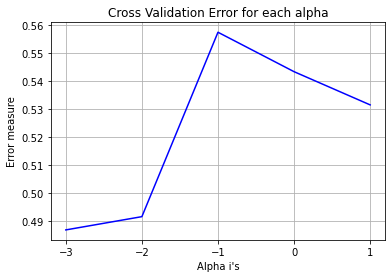

The Optimal C value is: 0.1


In [53]:
def cv_plot(alpha,auc):
    fig,ax=plt.subplots()
    ax.plot(np.log10(alpha),auc,c='b')
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()
alpha=np.logspace(-3,1,5)
cv_auc_score=[]
for i in alpha:
    model_log=SGDClassifier(alpha=i,penalty='l1',class_weight='balanced',loss='log',random_state=28)
    model_log.fit(X_train_final[selected_feaures],y_train)
    y_pred_prob=model_log.predict_proba(X_val_final[selected_feaures])[:,1]
    cv_auc_score.append(AUC(y_pred_prob,y_val))
    print('For alpha {0},cross validation AUC score {1}'.format(i,AUC(y_pred_prob,y_val)))
cv_plot(alpha,cv_auc_score)
print('The Optimal C value is:',alpha[np.argmax(cv_auc_score)])

## 对LightGBM进行网格调参

In [55]:
X_val_final=X_val_final.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+','',x))

### 确定max_depth 和 num_leaves

In [59]:
model_lgb=lgb.LGBMClassifier(boosting_type='gbdt',
                        objective='binary',
                        metrics='auc',
                        n_estimators=200,
                        learning_rate=0.1,
                        bagging_fraction=0.8,
                        feature_fraction=0.8)
parameters={'max_depth':range(4,8,1),'num_leaves':range(10,150,10)}
clf=GridSearchCV(model_lgb,parameters,cv=3,verbose=2)
clf.fit(X_train_final[selected_feaures],y_train)
score_test=roc_auc_score(y_val,clf.predict_proba(X_val_final[selected_feaures])[:,1])
print('LigthGBM GridSearchCV AUC Score:',score_test)
print('最优参数：')
print(clf.best_params_)

LigthGBM GridSearchCV AUC Score: 0.7667272277945394
最优参数：
{'max_depth': 7, 'num_leaves': 110}


### 确定min_data_in_leaf 和 max_bin 

In [60]:
model_lgb=lgb.LGBMClassifier(boosting_type='gbdt',
                        objective='binary',
                        metrics='auc',
                        n_estimators=200,
                        is_unbalance=True,
                        learning_rate=0.1,
                        max_depth=7,
                        num_leaves=110,
                        bagging_fraction=0.8,
                        feature_fraction=0.8)
# parameters={'max_bin':range(100,500,50),'min_data_in_leaf':range(100,150,10)}
# parameters={'max_bin':range(40,120,20),'min_data_in_leaf':range(70,120,10)}
parameters={'max_bin':range(10,50,10),'min_data_in_leaf':range(30,80,10)}
clf=GridSearchCV(model_lgb,parameters,cv=3,verbose=2)
clf.fit(X_train_final[selected_feaures],y_train)
score_test=roc_auc_score(y_val,clf.predict_proba(X_val_final[selected_feaures])[:,1])
print('LigthGBM GridSearchCV AUC Score:',score_test)
print('最优参数：')
print(clf.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ....................max_bin=10, min_data_in_leaf=30; total time=  11.0s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ....................max_bin=10, min_data_in_leaf=30; total time=  11.2s
[LightGBM] [Warning] feature_fraction is set=0.8, c

[CV] END ....................max_bin=20, min_data_in_leaf=40; total time=  11.4s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ....................max_bin=20, min_data_in_leaf=40; total time=  11.2s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ....................max_bin=20, min_data_in_leaf=40; total time=  11.8s
[LightGBM] [Warning] feature_fr

[CV] END ....................max_bin=30, min_data_in_leaf=50; total time=  11.8s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ....................max_bin=30, min_data_in_leaf=50; total time=  12.2s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ....................max_bin=30, min_data_in_leaf=60; total time=  12.2s
[LightGBM] [Warning] feature_fr

[CV] END ....................max_bin=40, min_data_in_leaf=60; total time=  12.0s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ....................max_bin=40, min_data_in_leaf=70; total time=  11.9s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ....................max_bin=40, min_data_in_leaf=70; total time=  12.4s
[LightGBM] [Warning] feature_fr

### 确定feature_fraction, bagging_fraction 和 bagging_freq 

In [61]:
model_lgb=lgb.LGBMClassifier(boosting_type='gbdt',
                        objective='binary',
                        metrics='auc',
                        n_estimators=200,
                        learning_rate=0.1,
                        max_depth=7,
                        num_leaves=110,
                        max_bin=30,
                        min_data_in_leaf=30,
                        bagging_fraction=0.8,
                        feature_fraction=0.8)
parameters={'feature_fraction':[0.6,0.7,0.8,0.9,1.0],
           'bagging_fraction':[0.6,0.7,0.8,0.9,1.0],
           'bagging_freq':range(0,10,2)}
clf=GridSearchCV(model_lgb,parameters,cv=3,verbose=2)
clf.fit(X_train_final[selected_feaures],y_train)
score_test=roc_auc_score(y_val,clf.predict_proba(X_val_final[selected_feaures])[:,1])
print('LigthGBM GridSearchCV AUC Score:',score_test)
print('最优参数：')
print(clf.best_params_)

Fitting 3 folds for each of 125 candidates, totalling 375 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[CV] END bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.6; total time=  10.7s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [War

[CV] END bagging_fraction=0.6, bagging_freq=0, feature_fraction=1.0; total time=  13.6s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[CV] END bagging_fraction=0.6, bagging_freq=2, feature_fraction=0.6; total time=   9.8s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.6, bagging_freq=2, feature_fraction=1.0; total time=  11.9s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[CV] END bagging_fraction=0.6, bagging_freq=4, feature_fraction=0.6; total time=   9.6s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.6, bagging_freq=4, feature_fraction=1.0; total time=  11.5s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[CV] END bagging_fraction=0.6, bagging_freq=6, feature_fraction=0.6; total time=   9.4s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.6, bagging_freq=6, feature_fraction=1.0; total time=  11.6s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV] END bagging_fraction=0.6, bagging_freq=8, feature_fraction=0.6; total time=   9.5s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.6, bagging_freq=8, feature_fraction=1.0; total time=  11.4s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[CV] END bagging_fraction=0.7, bagging_freq=0, feature_fraction=0.6; total time=  10.4s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.7, bagging_freq=0, feature_fraction=1.0; total time=  12.5s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[CV] END bagging_fraction=0.7, bagging_freq=2, feature_fraction=0.6; total time=  10.0s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.7, bagging_freq=2, feature_fraction=1.0; total time=  11.8s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[CV] END bagging_fraction=0.7, bagging_freq=4, feature_fraction=0.6; total time=   9.4s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.7, bagging_freq=4, feature_fraction=1.0; total time=  12.0s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[CV] END bagging_fraction=0.7, bagging_freq=6, feature_fraction=0.6; total time=   9.2s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.7, bagging_freq=6, feature_fraction=1.0; total time=  11.7s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV] END bagging_fraction=0.7, bagging_freq=8, feature_fraction=0.6; total time=   9.2s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.7, bagging_freq=8, feature_fraction=1.0; total time=  11.5s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[CV] END bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.6; total time=   9.8s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.8, bagging_freq=0, feature_fraction=1.0; total time=  13.2s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[CV] END bagging_fraction=0.8, bagging_freq=2, feature_fraction=0.6; total time=   9.7s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.8, bagging_freq=2, feature_fraction=1.0; total time=  13.7s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[CV] END bagging_fraction=0.8, bagging_freq=4, feature_fraction=0.6; total time=  10.4s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.8, bagging_freq=4, feature_fraction=1.0; total time=  12.5s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[CV] END bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.6; total time=   9.5s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.8, bagging_freq=6, feature_fraction=1.0; total time=  12.3s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV] END bagging_fraction=0.8, bagging_freq=8, feature_fraction=0.6; total time=   9.7s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.8, bagging_freq=8, feature_fraction=1.0; total time=  15.9s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[CV] END bagging_fraction=0.9, bagging_freq=0, feature_fraction=0.6; total time=   9.9s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.9, bagging_freq=0, feature_fraction=1.0; total time=  17.1s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[CV] END bagging_fraction=0.9, bagging_freq=2, feature_fraction=0.6; total time=  13.5s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.9, bagging_freq=2, feature_fraction=1.0; total time=  13.3s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[CV] END bagging_fraction=0.9, bagging_freq=4, feature_fraction=0.6; total time=  10.0s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.9, bagging_freq=4, feature_fraction=1.0; total time=  13.5s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[CV] END bagging_fraction=0.9, bagging_freq=6, feature_fraction=0.6; total time=  10.3s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.9, bagging_freq=6, feature_fraction=1.0; total time=  13.8s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV] END bagging_fraction=0.9, bagging_freq=8, feature_fraction=0.6; total time=   9.9s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=0.9, bagging_freq=8, feature_fraction=1.0; total time=  14.3s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[CV] END bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.6; total time=  10.6s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=1.0, bagging_freq=0, feature_fraction=1.0; total time=  12.7s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[CV] END bagging_fraction=1.0, bagging_freq=2, feature_fraction=0.6; total time=  10.2s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=1.0, bagging_freq=2, feature_fraction=1.0; total time=  13.4s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[CV] END bagging_fraction=1.0, bagging_freq=4, feature_fraction=0.6; total time=  10.3s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=1.0, bagging_freq=4, feature_fraction=1.0; total time=  12.5s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[CV] END bagging_fraction=1.0, bagging_freq=6, feature_fraction=0.6; total time=   9.9s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=1.0, bagging_freq=6, feature_fraction=1.0; total time=  13.0s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV] END bagging_fraction=1.0, bagging_freq=8, feature_fraction=0.6; total time=  10.1s
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fra

[CV] END bagging_fraction=1.0, bagging_freq=8, feature_fraction=1.0; total time=  12.5s
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
LigthGBM GridSearchCV AUC Score: 0.7662921490517323
最优参数：
{'bagging_fraction': 0.9, 'bagging_freq': 4, 'feature_fraction': 0.9}


## 对随机森林进行随机搜索

In [62]:
model_rand=RandomForestClassifier()
parameters={'n_estimators':[10,20,30,50],'max_depth':[5,7,11,13],'max_features':range(1,11,1),'min_samples_split':range(80,150,20), 'min_samples_leaf':range(10,60,10)}
clf=RandomizedSearchCV(model_rand,parameters,cv=3,verbose=2)
clf.fit(X_train_final[selected_feaures],y_train)
score_test=roc_auc_score(y_val,clf.predict_proba(X_val_final[selected_feaures])[:,1])
print('RandomForestClassifier RandomizedSearchCV AUC Score:',score_test)
print('最优参数：')
print(clf.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=13, max_features=2, min_samples_leaf=10, min_samples_split=120, n_estimators=50; total time=   8.5s
[CV] END max_depth=13, max_features=2, min_samples_leaf=10, min_samples_split=120, n_estimators=50; total time=   8.7s
[CV] END max_depth=13, max_features=2, min_samples_leaf=10, min_samples_split=120, n_estimators=50; total time=   9.8s
[CV] END max_depth=13, max_features=4, min_samples_leaf=50, min_samples_split=100, n_estimators=30; total time=   9.1s
[CV] END max_depth=13, max_features=4, min_samples_leaf=50, min_samples_split=100, n_estimators=30; total time=   9.0s
[CV] END max_depth=13, max_features=4, min_samples_leaf=50, min_samples_split=100, n_estimators=30; total time=  10.4s
[CV] END max_depth=13, max_features=4, min_samples_leaf=50, min_samples_split=120, n_estimators=30; total time=   8.0s
[CV] END max_depth=13, max_features=4, min_samples_leaf=50, min_samples_split=120, n_estimators=30; total 

# 模型结果

In [63]:
#逻辑回归
model_log=SGDClassifier(alpha=0.1,penalty='l1',class_weight='balanced',loss='log',random_state=28)
model_log.fit(X_train_final[selected_feaures],y_train)
y_pred_log=model_log.predict_proba(X_val_final[selected_feaures])[:,1]
fpr_val_log,tpr_val_log,_=roc_curve(y_val,y_pred_log)
print('逻辑回归测试集')
print('AUC',AUC(y_pred_log,y_val))

逻辑回归测试集
AUC 0.5573840714181477


In [65]:
#随机森林
model_rand=RandomForestClassifier(n_estimators=50, 
                                  min_samples_split= 120, 
                                  min_samples_leaf=10, 
                                  max_features=2, 
                                  max_depth=13)
model_rand.fit(X_train_final[selected_feaures],y_train)
y_pred_rand=model_rand.predict_proba(X_val_final[selected_feaures])[:,1]
fpr_val_rand,tpr_val_rand,_=roc_curve(y_val,y_pred_rand)
print('随机森林测试集')
print('AUC',AUC(y_pred_rand,y_val))


随机森林测试集
AUC 0.728089963235228


In [112]:
#LightGBM

model_lgb=lgb.LGBMClassifier(boosting_type='gbdt',
                        objective='binary',
                        metrics='auc',
                        n_estimators=2000,
                        learning_rate=0.01,
                        max_depth=7,
                        num_leaves=110,
                        max_bin=20,
                        min_data_in_leaf=30,
                        bagging_fraction=0.9,
                        feature_fraction=0.9,
                        bagging_freq=4)
model_lgb.fit(X_train_final[selected_feaures],y_train)
y_pred_lgb=model_lgb.predict_proba(X_val_final[selected_feaures])[:,1]
fpr_val_lgb,tpr_val_lgb,_=roc_curve(y_val,y_pred_lgb)
print('LightGBM测试集')
print('AUC',AUC(y_pred_lgb,y_val))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
LightGBM测试集
AUC 0.7752055329136497


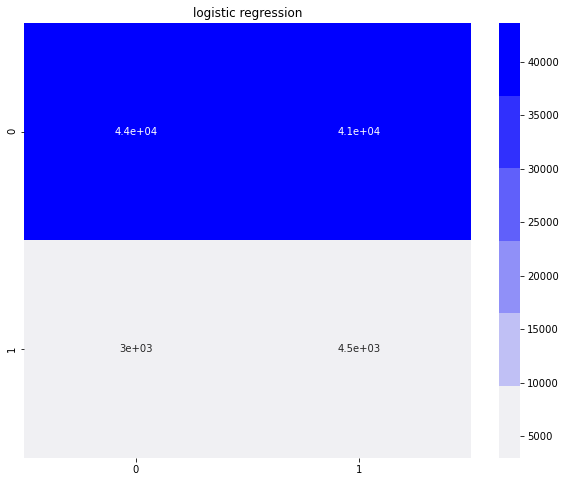

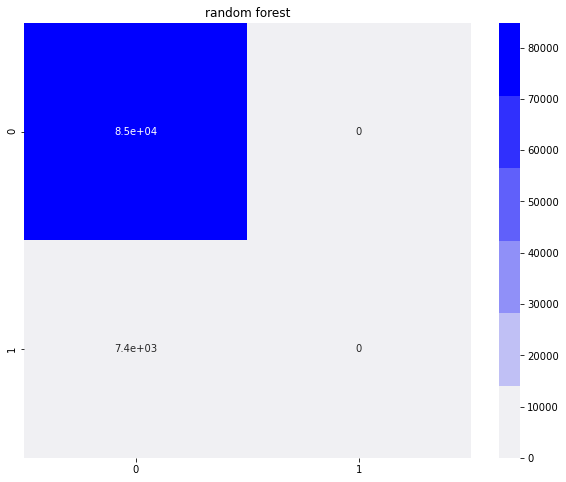

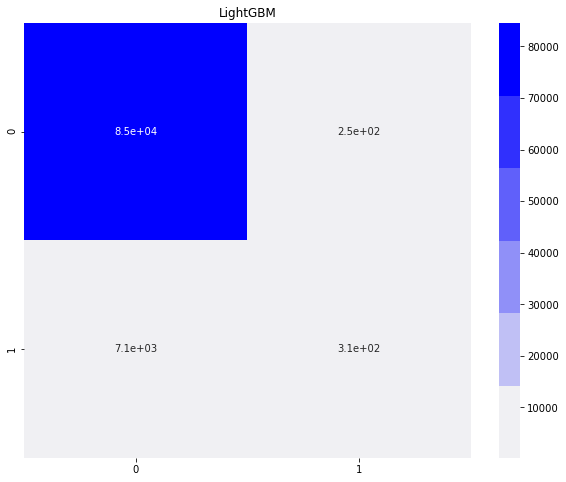

In [74]:
fig=plt.figure(figsize=(10,8))
y_pred_log=model_log.predict(X_val_final[selected_feaures])
C=confusion_matrix(y_val,y_pred_log)
cmap=sns.light_palette("blue")
sns.heatmap(C,annot=True,cmap=cmap)
plt.title('logistic regression')
plt.show()
fig=plt.figure(figsize=(10,8))
y_pred_rand=model_rand.predict(X_val_final[selected_feaures])
C=confusion_matrix(y_val,y_pred_rand)
cmap=sns.light_palette("blue")
sns.heatmap(C,annot=True,cmap=cmap)
plt.title('random forest')
plt.show()
fig=plt.figure(figsize=(10,8))
y_pred_lgb=model_lgb.predict(X_val_final[selected_feaures])
C=confusion_matrix(y_val,y_pred_lgb)
cmap=sns.light_palette("blue")
sns.heatmap(C,annot=True,cmap=cmap)
plt.title('LightGBM')
plt.show()


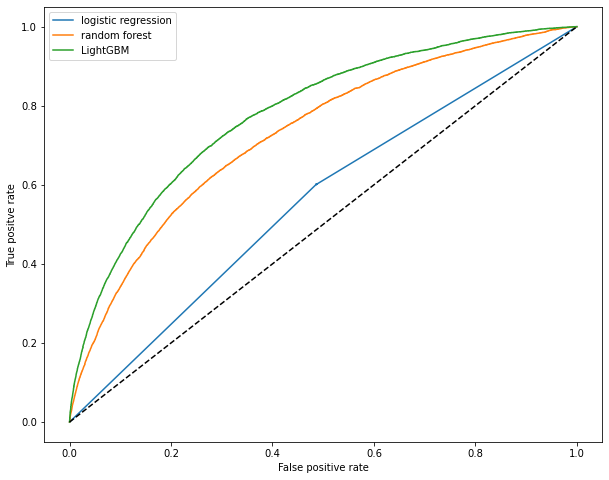

In [75]:
fig=plt.figure(figsize=(10,8))
plt.plot(fpr_val_log,tpr_val_log,label='logistic regression')
plt.plot(fpr_val_rand,tpr_val_rand,label='random forest')
plt.plot(fpr_val_lgb,tpr_val_lgb,label='LightGBM')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positve rate')
plt.legend(loc='best')
plt.show()

In [86]:
test_final=test_final.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+','',x))

In [113]:
y_pred=model_lgb.predict_proba(test_final[selected_feaures])[:,1]

In [114]:
y_pred=pd.DataFrame(y_pred,columns=['TARGET'])

In [115]:
y_pred=pd.concat([id_test,y_pred],axis=1)

In [116]:
y_pred.to_csv('result1.csv',index=0)

![](000.png)